In [1045]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.integrate import solve_ivp
plt.style.use('seaborn-darkgrid')
import datetime
from copy import deepcopy
from scipy.stats import norm
from scipy.optimize import differential_evolution
import pdb
from IPython.core.display import HTML
from math import ceil, floor
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import chain
from scipy.signal import savgol_filter
from scipy.special import expit
from scipy.integrate import solve_ivp
from itertools import product

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [70]:
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])
        
    def train_data(self, threshold):
        self.fetch()
        index = np.where(self.cases_time_series["totaldeceased"] > threshold)[0][0]
        startdate = self.cases_time_series["date"][index]
        return self.cases_time_series["totaldeceased"][index:], startdate

In [71]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased' : [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

The SEIR model is defined as 

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dE}{dt} = \frac{RIS}{T_{inf}}  - \frac{E}{T_{inc}} 
$$

$$
\frac{dI}{dt} = \frac{E}{T_{inc}}  - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{I}{T_{inf}} 
$$

$S, E, I, X$ are respectively the number of people that are susceptible, exposed, infected and removed. $R$ is the time-dependent value of the basic reproduction number. $T_{inf}$, $T_{inc}$ are the average infection and incubation periods respectively. $R$ can be related to social distancing data as follows

$$
R =  \lambda(\Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w})
$$

here $\lambda$ is a tunable parameter and other values are

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces


In [933]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (E / T_inc)

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (E / T_inc) - (I / T_inf)

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (I / T_inf)

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = S + dS_dt(S, I, reproduction, T_inf)
    E_out = E + dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = I + dI_dt(I, E, T_inc, T_inf)
    R_out = R + dR_dt(I, T_inf)

    return [S_out, E_out, I_out, R_out]

def SIR_model(t, y, R_t, case_mortality, T_inf, T_inc, *R_args):
    if callable(R_t):
        print(R_args)
        reproduction = R_t(t, *R_args)
    else:
        reproduction = R_t
    
    S, I, R = y
    S_out = S + dS_dt(S, I, reproduction, T_inf)
    I_out = I + dI_dt(I, 0, T_inc, T_inf) - dS_dt(S, I, reproduction, T_inf)
    R_out = R + dR_dt(I, T_inf) * case_mortality

    return [S_out, I_out, R_out]

## Check Equations
R_0 is taken as a constant; check if the equations are correct <br/>
Parameters taken from https://gabgoh.github.io/COVID/index.html

## Fitting with real data - NYC


In [36]:
# Fetch data from NYC
! rm time_series_covid19_deaths_US.csv*
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

raw_data_us = pd.read_csv("time_series_covid19_deaths_US.csv")
start_date = datetime.date(2020, 1, 22)
date_format = "%-m/%-d/%y"

# Extract NYC time_series data
deaths_time_series_nyc = []
date = deepcopy(start_date)
df_nyc = raw_data_us[raw_data_us['Combined_Key'].str.contains("New York City")]
df_nyc_cols = df_nyc.columns.values

while date.strftime(date_format) in df_nyc_cols:
    deaths_time_series_nyc.extend(df_nyc[date.strftime(date_format)].values)
    date = date + datetime.timedelta(days=1)

deaths_time_series_nyc = np.array(deaths_time_series_nyc)
deaths_time_series_nyc[1:] = np.diff(deaths_time_series_nyc)

2020-05-27 02:42:01 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv [1177355/1177355] -> "time_series_covid19_deaths_US.csv" [1]


In [76]:
# start_date_sd = datetime.date(2020, 2, 15)
# df_sd = pd.read_csv("Global_Mobility_Report.csv")
# df_sd = df_sd[df_sd['country_region_code'] == 'US']

# counties = ["New York County", "Kings County", "Bronx County", "Queens County"]
# sd_data = 
# df_sd[df_sd['sub_region_2'] == "Kings County"]

In [126]:
def smoothen(X, std):
    result = np.zeros_like(X)
    
    for i, _ in enumerate(X):
        norm_factor = 0
        for j, _X in enumerate(X):
            val = norm.pdf(j, loc=i, scale=std)
            result[i] += _X * val
            norm_factor += val
        result[i] /= norm_factor
    
    return result

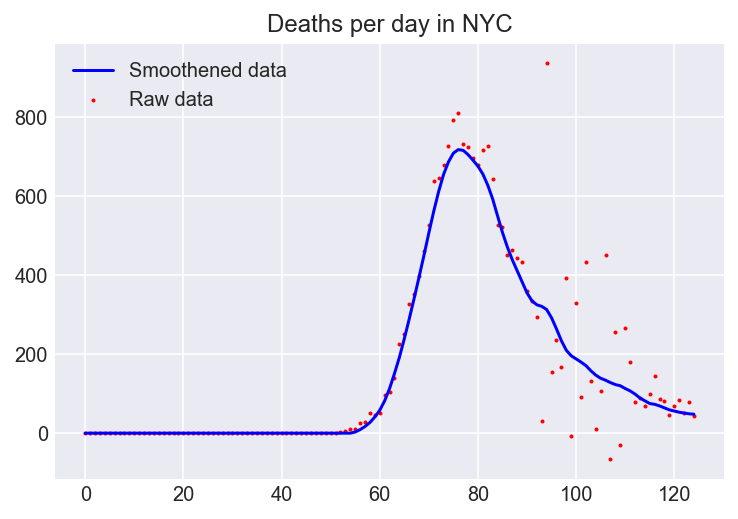

In [555]:
# Data visualization
smooth_data_nyc = smoothen(smoothen(smoothen(smoothen(smoothen(deaths_time_series_nyc, 1), 1), 1), 1), 1)

plt.scatter(np.arange(smooth_data_nyc.shape[0]), deaths_time_series_nyc, label="Raw data", s=1, c='red')
plt.plot(smooth_data_nyc, label="Smoothened data", c='blue')
plt.legend()
plt.title("Deaths per day in NYC")
plt.show()

In [304]:
def rmse_loss(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

In [305]:
def simple_seir(t_max, pop, I_init, R):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    E = 0
    I = I_init
    X = 0

    for t in range(1, t_max + 1):
        S, E, I, X = SEIR_model(t, [S, E, I, X], R, T_inf, T_inc)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

In [928]:
def simple_sir(t_max, pop, I_init, R, case_mortality, T_inf, offset, integrate=False):
    S = 1
    I = I_init
    X = 0
    
    if not integrate:
        # This computes values using a FSM
        result = np.zeros(t_max + 1, dtype=float)
        result[0] = 0

        for t in range(1, t_max + 1):
            S, I, X = SIR_model(t, [S, I, X], R, case_mortality, T_inf, 1)
            result[t] = X 
    else:
        # This computes values using a Runge-Kutta method of order 5
        integral = solve_ivp(fun=SIR_model, 
                             t_span=(0, t_max + 1),
                             t_eval=np.arange(0, t_max + 1),
                             y0=[S, I, X],
                             args=(R, case_mortality, T_inf, 1))

        result = integral.y[2]
    
    result[1:] = np.diff(result)
    return result * pop

In [948]:
def run_model(*params, return_preds=False, integrate=False):
    model, loss_fun, daily_deaths = params[-3:]
    
    offset = int(params[0][0])
    t_max = daily_deaths[offset:].shape[0] - 1
    preds = model(t_max, *params[0], integrate=integrate)

    loss = loss_fun(preds, daily_deaths[offset:])
    
    if not return_preds:
        return loss
    else:
        return loss, preds

In [625]:
def fit_model(*model_args, bounds=None, verbose=True):

    def print_progress(xk, convergence=0):                
        if verbose:
            np.set_printoptions(
                formatter={
                    'float': lambda x: "{:.1e}".format(x)
                }
            )
            
            if xk.shape[0] > 6:
                print("x0: {} conv: {:.3e}".format(xk[:6], convergence), end="\r")
            else:
                print("x0: {} conv: {:.3e}".format(xk, convergence), end="\r")


    result = differential_evolution(run_model,
                                    args=model_args,
                                    bounds=bounds,
                                    callback=print_progress)

    print(result.message)
    return result.x

In [486]:
def get_model_stats(model, loss_fun, data, breakpoints, plot_title, bounds, param_cols, huge=False):
    df = pd.DataFrame()
    df['Breakpoint'] = []
    df['Loss']       = []
    
    
    for col in param_cols:
        df[col] = []
    
    time_values = np.arange(data.shape[0])
    
    if huge:
        col_num = 2
        row_num = ceil(len(breakpoints) / col_num)
        fig, axs = plt.subplots(row_num, col_num, figsize=(25, 10 * row_num), sharex=True, sharey=True)
    else:
        col_num = 3
        row_num = ceil(len(breakpoints) / col_num)
        fig, axs = plt.subplots(row_num, col_num, figsize=(15, 4 * row_num), sharex=True, sharey=True)
    
    for b, ax in zip(breakpoints, axs.flat):
        params = fit_model(model, loss_fun, data[:b], bounds=bounds, verbose=True)
        offset = int(params[0])
        
        loss, preds = run_model(params, model, loss_fun, data, return_preds=True)
  
        ax.plot(time_values[offset:], preds, label="Projected deaths")
        ax.scatter(time_values[:b], data[:b], s=2, c='green', label="Used points")
        ax.scatter(time_values[b:], data[b:], s=2, c='red', label="Unused points")
        ax.axvspan(b, time_values[-1], facecolor='r', alpha=0.2)
        ax.set_title("NYC | {} days".format(b))
        ax.set_xlabel("Days")
        ax.set_ylabel("Deaths")
        ax.legend()
        

        df_dict = {
            "Breakpoint": [b],
            "Loss"      : [loss],
        }

        for i, col in enumerate(param_cols):
            df_dict[col] = [params[i]]

        df = df.append(pd.DataFrame(df_dict))
    
    fig.suptitle(plot_title, fontsize=15)
    fig.tight_layout(pad=2.0)
    return df

<h2>Fitting a SIR model without social distancing</h2>

Simple SIR model to test the code and get baseline statistics

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dI}{dt} = \frac{RIS}{T_{inf}}   - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{\lambda I}{T_{inf}} 
$$

Here, $R$ is the reproduction number, $\lambda$ is the fraction of people who die (it is assumed that people die and recover at the same rate). The tunable parameters are 

* $R$ - (fixed) reproduction number 
* $\lambda$ - the fraction of recovered people who die
* $\texttt{offset}$ - from where to start the prediction, 
* $I_0$ - the initial number of infected people
* $T_{inf}$ - the average time for which a person remains infectious (regardless of whether they die or not)

We can see a problem here -- the SIR model is not able to predict a long tail for the deaths. This is because in the absence of lockdown measures, the disease spreads through the population rapidly, infecting everyone in a short time. Lockdown measures serve to clamp down on the transmissibility of the disease.

In [342]:
# Get interactive plot
def plot_sir(offset, pop, I_init, R, mort, T_inf, daily_deaths):
    time_values = np.arange(daily_deaths.shape[0])
    t_max = time_values[offset:].shape[0] - 1
    
    preds = simple_sir(t_max, pop, I_init, R, mort, T_inf)
    
    
    plt.plot(time_values[offset:], preds, label="Projected deaths")
    plt.plot(time_values, daily_deaths, '.', label="Actual deaths")
    plt.title("Interactive SIR plot")
    plt.show()

interact(plot_sir, offset=10, pop=82206, I_init=0.000197, R=3, mort=0.105688, T_inf=6, daily_deaths=fixed(smooth_data_nyc))

interactive(children=(IntSlider(value=10, description='offset', max=30, min=-10), IntSlider(value=82206, descr…

<function __main__.plot_sir(offset, pop, I_init, R, mort, T_inf, daily_deaths)>

Optimization terminated successfully.6.8e-03 6.0e+00] conv: 1.060e+00
Optimization terminated successfully.5.1e-03 6.2e+00] conv: 1.390e+00
Optimization terminated successfully.1.1e-02 6.9e+00] conv: 1.038e+00
Optimization terminated successfully.2.0e-02 7.5e+00] conv: 1.036e+00
Optimization terminated successfully.5.2e-03 7.9e+00] conv: 1.060e+00
Optimization terminated successfully.5.4e-03 8.0e+00] conv: 1.028e+00


Breakpoint       Loss     offset           pop        I_init         R  \
0        70.0  71.503368  15.644001  2.718505e+06  8.699973e-07  2.599896   
0        80.0  77.911594  29.681924  3.427042e+06  3.267401e-05  2.599478   
0        90.0  52.739395  33.946382  1.774317e+06  1.665577e-04  2.599739   
0       100.0  35.684732   0.443438  1.069667e+06  5.184524e-07  2.599809   
0       110.0  33.251169   0.302084  4.252837e+06  9.621021e-07  2.595974   
0       120.0  34.533332  11.915167  4.110469e+06  8.121622e-06  2.599076   

       mort     T_inf  
0  0.006835  6.000144  
0  0.005128  6.179593  
0  0.011261  6.905391  
0  0.020018  7.527935  
0  0.005206  7.897868  
0  0.005432  7.996042

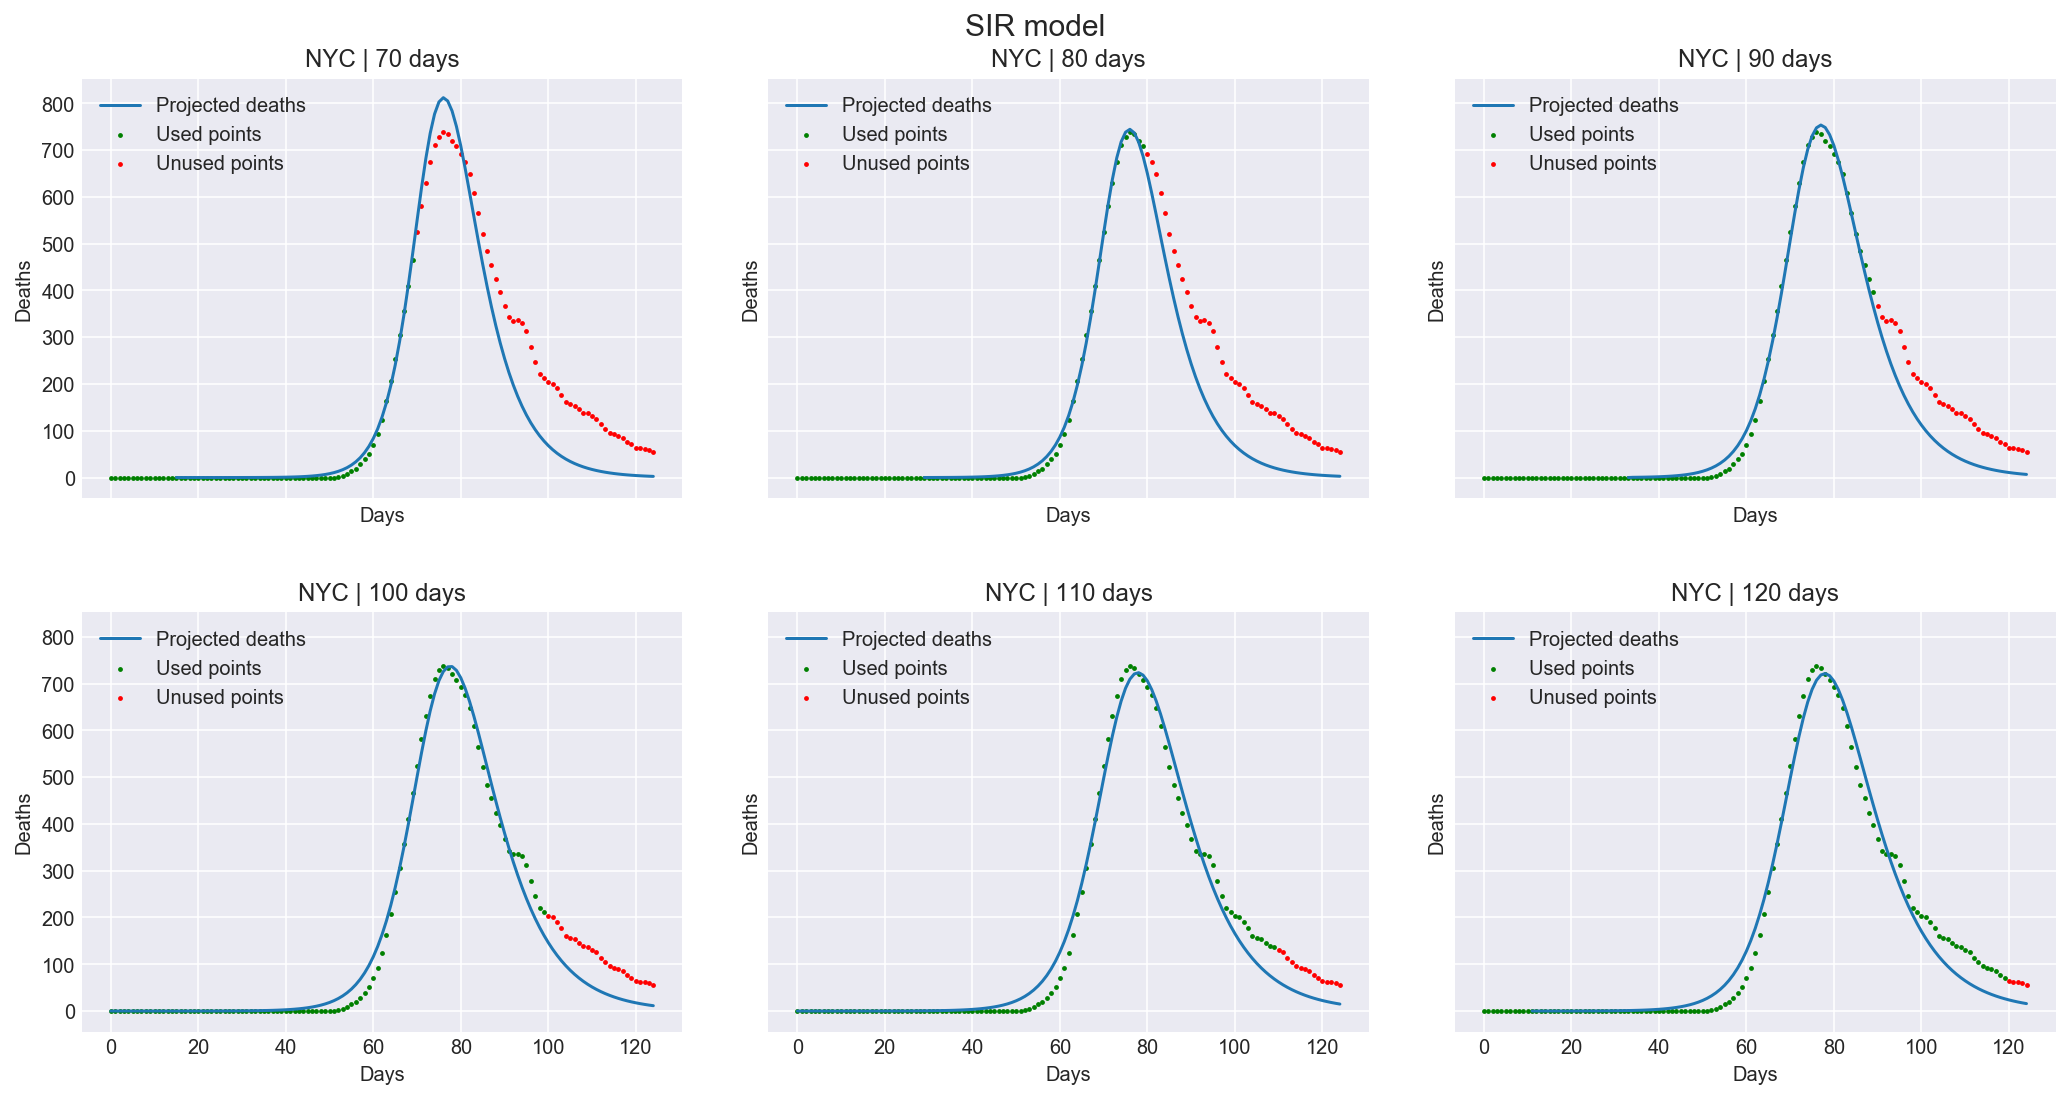

In [398]:
get_model_stats(simple_sir, rmse_loss, smooth_data_nyc, range(70, 130, 10), "SIR model", 
                param_cols=["offset", "pop", "I_init", "R", "mort", "T_inf"],
                bounds=[(0, 50), (1e6, 8.4e6), (0, 1e-3), (1, 2.6), (0, 5e-2), (6, 8)])

<h2>Social distancing in NYC</h2>

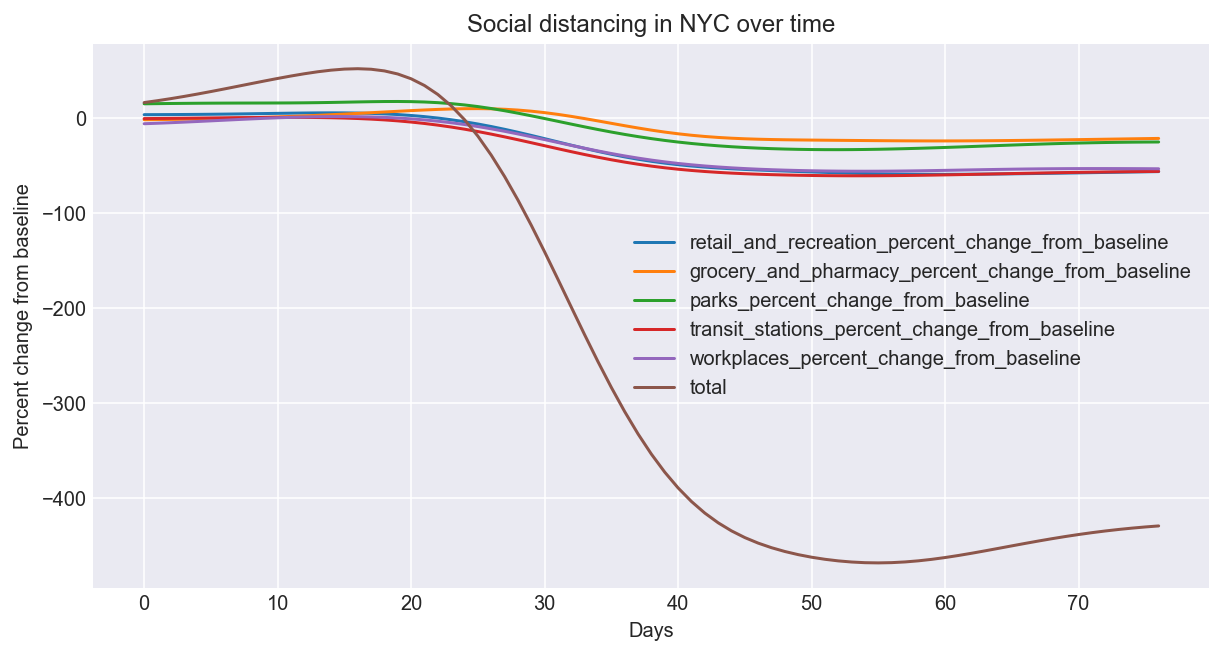

In [390]:
# Preprocess social distancing data from Google
start_date_sd = datetime.date(2020, 2, 15)
end_date_sd   = datetime.date(2020, 5, 1)
date_format_sd = "%Y-%m-%d"
smoothening_factor = 6

df_sd = pd.read_csv("Global_Mobility_Report.csv")
df_sd = df_sd[df_sd['country_region_code'] == 'US']

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

# Counties which NYC covers -- population data from Wikipedia
counties = {"New York County" : 1628706, 
            "Kings County"    : 2559903, 
            "Bronx County"    : 1418207, 
            "Queens County"   : 2253858}

total_pop = 0.
for c in counties.keys():
    total_pop += counties[c]

agg_sd_nyc = {}
for cat in categories:
    agg_sd_nyc[cat] = []

curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    
    val = {}
    
    for c in counties.keys():
        df_county = df_sd_curr[df_sd_curr["sub_region_2"] == c]
        
        for cat in categories:
            if cat in val:
                val[cat] += counties[c] * np.array(df_county[cat])[0]
            else:
                val[cat] = counties[c] * np.array(df_county[cat])[0]
                
    for cat in categories:
        val[cat] /= total_pop
        agg_sd_nyc[cat].append(val[cat])
    
    curr_date = curr_date + datetime.timedelta(days=1)
    
agg_sd_nyc["total"] = np.zeros(len(agg_sd_nyc[categories[0]]))

# Get the total
for cat in agg_sd_nyc.keys():
    agg_sd_nyc[cat] = np.array(agg_sd_nyc[cat])
    agg_sd_nyc["total"] += agg_sd_nyc[cat]

# Plot the array
plt.figure(figsize=(10,5))
for label in agg_sd_nyc.keys():
    agg_sd_nyc[label] = smoothen(agg_sd_nyc[label], smoothening_factor)
    plt.plot(agg_sd_nyc[label], label=label)

plt.title("Social distancing in NYC over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

We now use a time-dependent $R$ value 

$$R(t) = R_0 + \mu \cdot s$$

where $R_0, \mu$ are tunable parameters and $s$ is the social distancing metric written as the sum

$$
s = \Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w}
$$

where each of the terms on the RHS above denote percentage change from baseline in mobility at the following locations

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces

In [941]:
# Definition of the model
def R_sd(t, R_0, mu, sd_offset, sd_metric, offset):
    sd_offset = int(sd_offset)
    offset = int(offset)
    
    if t + sd_offset + offset >= sd_metric.shape[0]:
#         print(R_0 + mu * sd_metric[-1])
        return R_0 + mu * sd_metric[-1]
    else:
#         print(R_0 + mu * sd_metric[-1])
        return R_0 + mu * sd_metric[t + sd_offset + offset]

def R_sd_v2(t, R_max, R_min, sd_offset, sd_metric, offset):    
    sd_offset = int(sd_offset)
    offset = int(offset)
    
    sd_max = np.max(sd_metric)
    sd_min = np.min(sd_metric)
    
    if t + sd_offset + offset >= sd_metric.shape[0]:
        sd = sd_metric[-1]
    else:
        shifted_t = t + sd_offset + offset
        low_sd = sd_metric[floor(shifted_t)]
        high_sd = sd_metric[ceil(shifted_t)]
        sd = low_sd + (shifted_t - floor(shifted_t)) * (high_sd - low_sd)
    
    return R_max - (R_max - R_min) * (sd_max - sd) /  (sd_max - sd_min)
    
def sir_sd(t_max, offset, pop,  I_init, case_mortality, T_inf, R_0, mu, sd_offset):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    I = I_init
    X = 0
    
    for t in range(1, t_max + 1):
        S, I, X = SIR_model(t, [S, I, X], R_sd_v2, case_mortality, T_inf, 1, R_0, mu, sd_offset, padded_sd, offset)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

Optimization terminated successfully.6.0e+00 2.7e+00 8.6e-01 2.0e+01] conv: 1.741e+00
Optimization terminated successfully.6.0e+00 2.7e+00 8.7e-01 1.9e+01] conv: 1.027e+00
Optimization terminated successfully.7.1e+00 2.7e+00 8.5e-01 2.0e+01] conv: 1.009e+00
Optimization terminated successfully.7.9e+00 2.7e+00 9.0e-01 2.0e+01] conv: 2.182e+00
Optimization terminated successfully.8.0e+00 2.7e+00 9.0e-01 2.0e+01] conv: 1.659e+00


Breakpoint        Loss     offset           pop    I_init      mort  \
0        65.0  141.855185  40.341119  8.362111e+06  0.000515  0.001460   
0        70.0  170.611415  46.525468  8.356309e+06  0.002642  0.001225   
0        75.0   86.813525  49.361323  8.352011e+06  0.005886  0.001925   
0        80.0   33.720755  49.030496  8.311831e+06  0.006533  0.002429   
0        85.0   17.932815  40.955350  8.391125e+06  0.001265  0.002626   

      T_inf     R_max   delta_R  sd_offset  
0  6.000000  2.700000  0.867303  19.708708  
0  6.000000  2.700000  0.850000  19.185332  
0  7.148663  2.700000  0.854669  19.835801  
0  7.932163  2.700000  0.900000  19.988567  
0  8.000000  2.666056  0.899821  19.749537

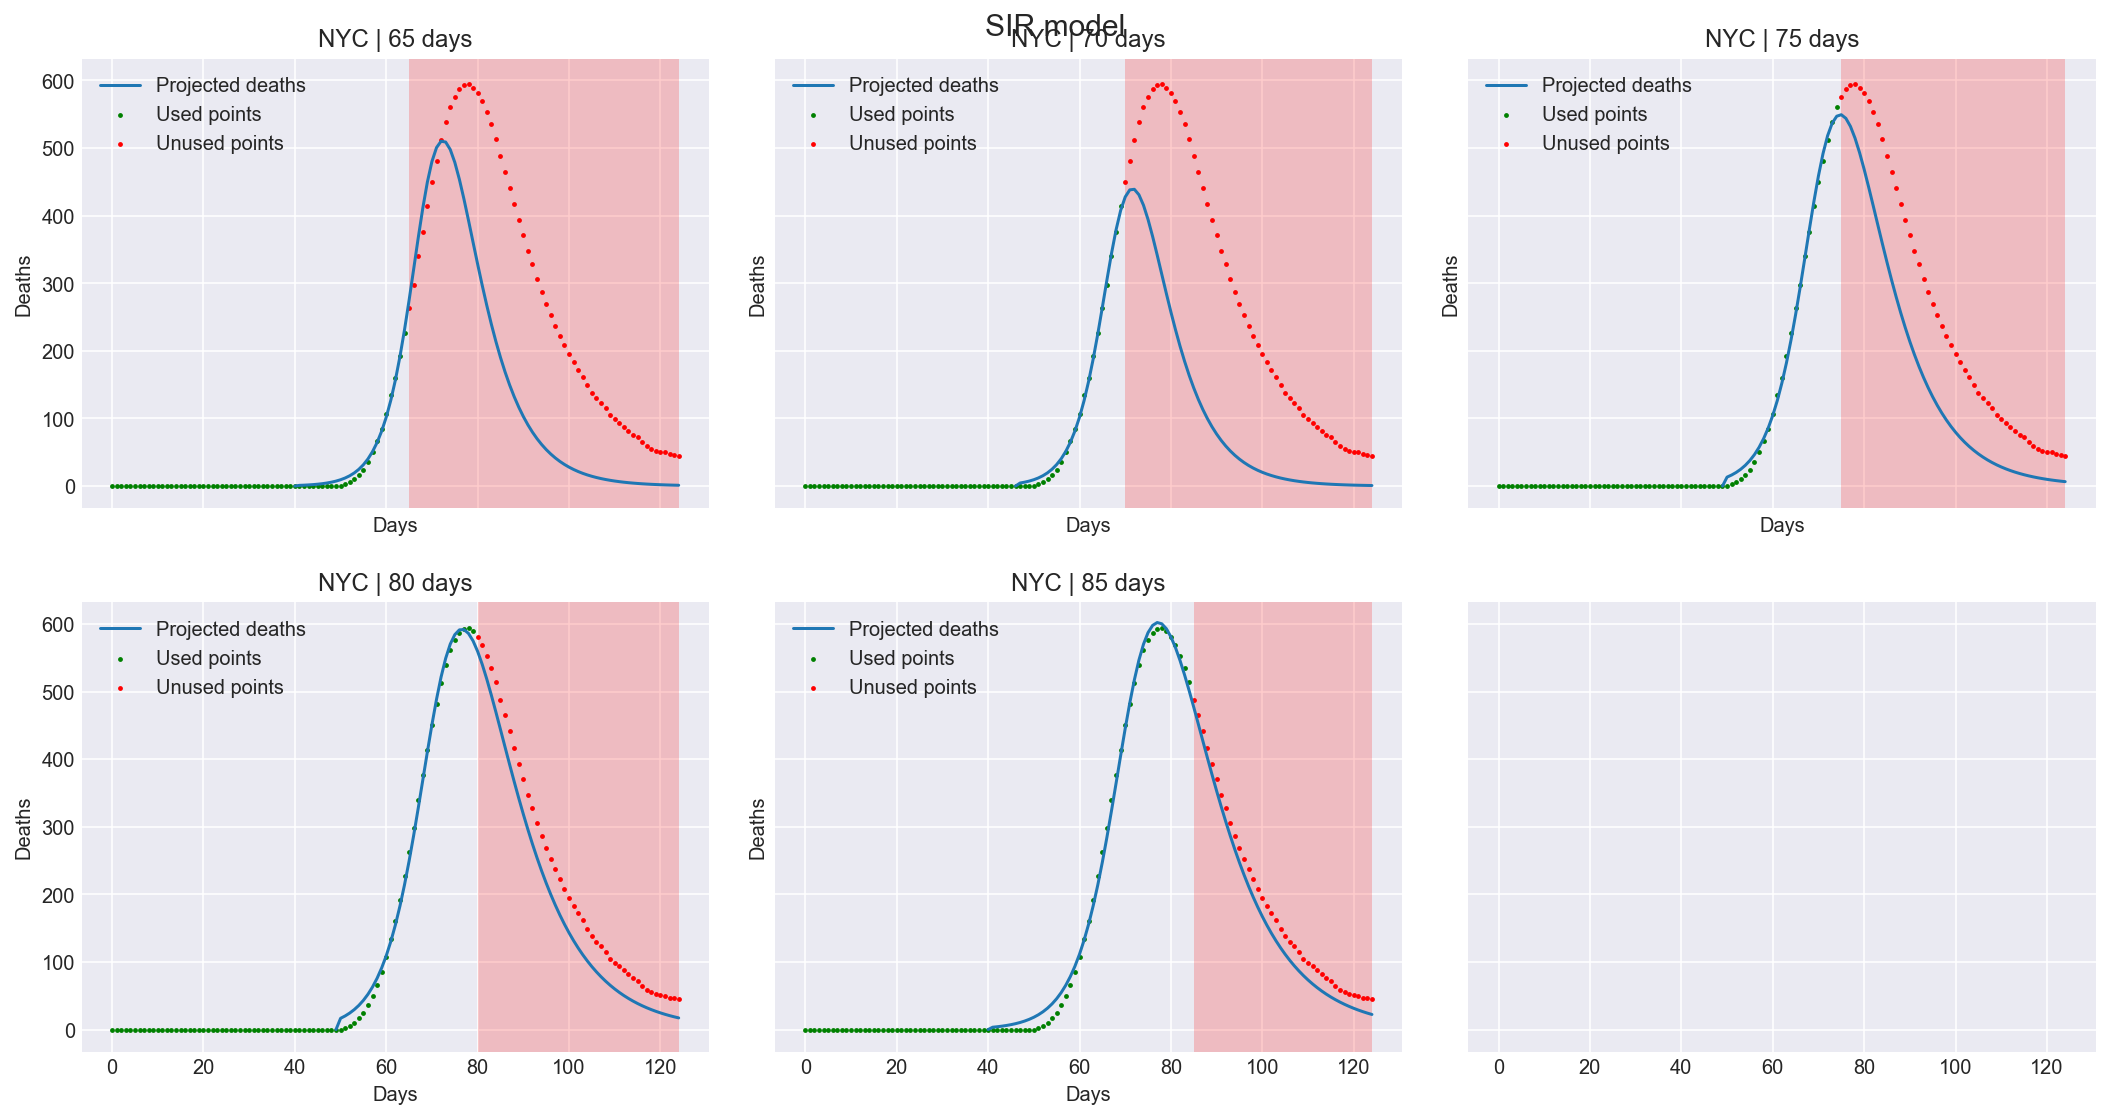

In [533]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_nyc["total"][0], agg_sd_nyc["total"])) 

get_model_stats(sir_sd, rmse_loss, smooth_data_nyc, list(range(65, 90, 5)), "SIR model", 
                param_cols=["offset", "pop", "I_init", "mort", "T_inf", "R_max", "delta_R", "sd_offset"],
                bounds=[(40, 50), (8.3e6, 8.4e6), (1e-6, 1e-2), (0, 5e-2), (6, 8), (1, 2.7), (0.85, 0.9), (10, 20)])

We see that the long-tail problem has been somewhat mitigated. However, the peak prediction is still bad because the model does not fit well to the initial part of the curve.

<h1>SIRD model with social distancing</h1>

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dI}{dt} = \frac{RIS}{T_{inf}}   - \frac{I}{T_{inf}}
$$

$$
\frac{dX}{dt} = \gamma_XI
$$


In [959]:
def SIRD_fsm(t, y, R_t, T_inf, gamma_x, *R_args):
    if callable(R_t):
        R = R_t(t, *R_args)
    else:
        R = R_t
    
    S, I, X = y
#     print("R: {}".format(R))
    
    S_out = S - (R * I * S / T_inf)
    I_out = I + (R * I * S / T_inf) - I / T_inf
    X_out = X + gamma_x * I

    return [S_out, I_out, X_out]

def sird_sd(t_max, offset, pop,  I_init, T_inf, gamma_x, R_0, mu, sd_offset, integrate=False):
    S = 1
    I = I_init
    X = 0
    
    if not integrate:
        result = np.zeros(t_max + 1, dtype=float)
        result[0] = 0
#     This computes values using a FSM
        for t in range(1, t_max + 1):
            S, I, X = SIRD_fsm(t, [S, I, X], R_sd_v2, T_inf, gamma_x, R_0, mu, sd_offset, padded_sd, offset)
            result[t] = X 
    else:
        # This computes values using a Runge-Kutta method of order 5
        print("Solving IVP...")
        integral = solve_ivp(fun=SIRD_fsm, 
                             t_span=(0, t_max + 1),
                             t_eval=np.arange(0, t_max + 1),
                             y0=[S, I, X],
                             args=(R_sd_v2, T_inf, gamma_x, R_0, mu, sd_offset, padded_sd, offset))
        print("Done!")
        result = integral.y[2]
    
    result[1:] = np.diff(result)
    return result * pop

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.
Optimization terminated successfully.2.0e-03 2.3e+00] conv: 2.650e+00
Optimization terminated successfully.2.0e-03 2.3e+00] conv: 1.077e+00
Optimization terminated successfully.1.1e-03 2.3e+00] conv: 1.311e+00
Optimization terminated successfully.1.0e-03 2.3e+00] conv: 1.006e+00
Optimization terminated successfully.9.6e-04 2.3e+00] conv: 1.668e+00
Optimization terminated successfully.8.9e-04 2.3e+00] conv: 1.066e+00
Optimization terminated successfully.1.4e-03 2.3e+00] conv: 2.030e+00
Optimization terminated successfully.1.5e-03 2.3e+00] conv: 1.098e+00


Breakpoint        Loss     offset        pop    I_init     T_inf   gamma_x  \
0        60.0  127.364671  40.612111  8400000.0  0.000030  5.000000  0.002000   
0        65.0  162.456683  40.592373  8400000.0  0.000059  5.000065  0.002000   
0        70.0  175.155684  40.578756  8400000.0  0.000064  5.001254  0.001997   
0        75.0   36.025440  40.429216  8400000.0  0.000123  5.000000  0.001113   
0        80.0   42.664001  41.812305  8400000.0  0.000168  5.000162  0.001026   
0        85.0   36.155754  40.554157  8400000.0  0.000143  5.002046  0.000957   
0        90.0   36.089516  42.514179  8400000.0  0.000234  5.000192  0.000893   
0        95.0   21.809079  40.714203  8400000.0  0.000100  5.000178  0.001409   
0       120.0   17.659912  40.693720  8400000.0  0.000119  5.216026  0.001468   

      R_max     R_min  sd_offset  
0  2.300000  0.915493  21.905055  
0  2.299891  0.988896  20.921744  
0  2.299900  0.986955  20.712387  
0  2.300000  0.850000  20.877177  
0  2.299925  0.857634  20.436722  
0  2.299832  0.933340  20.622063  
0  2.300000  0.986317  20.602307  
0  2.300000  0.850000  21.684637  
0  2.299597  0.850120  21.566170

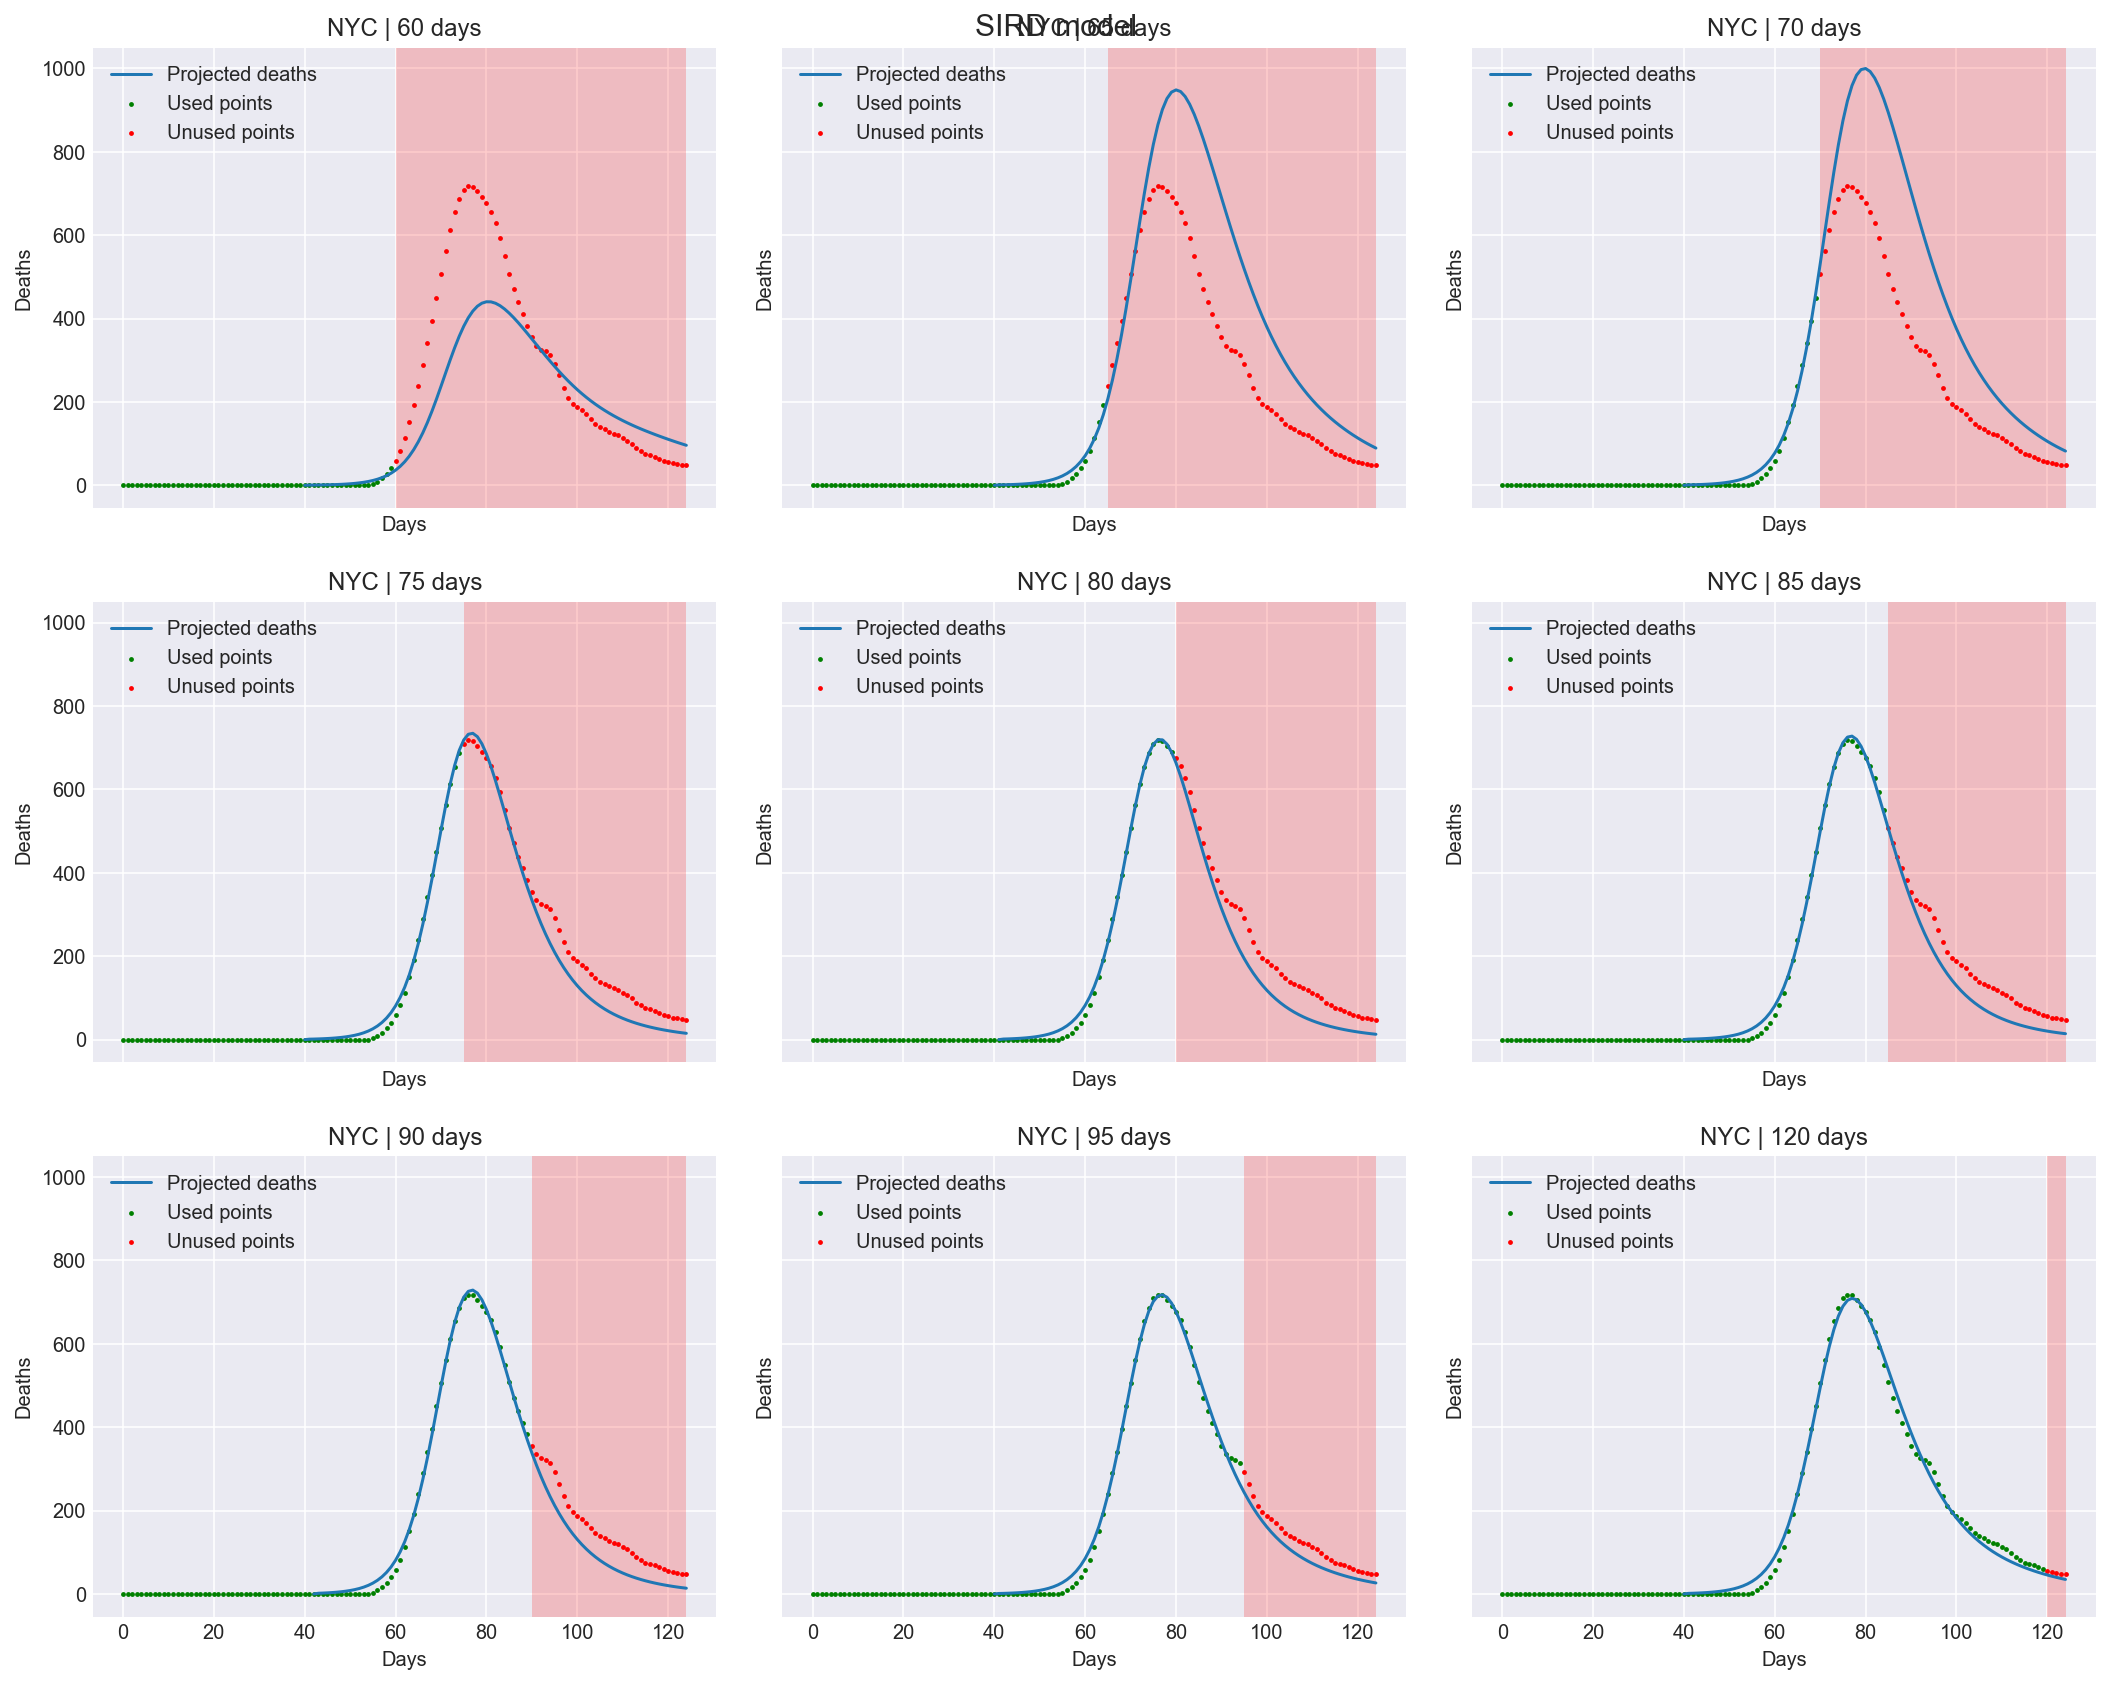

In [775]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_nyc["total"][0], agg_sd_nyc["total"])) 

get_model_stats(sird_sd, rmse_loss, smooth_data_nyc, list(range(60, 100, 5)) + [120], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                bounds=[(40, 45), (8.4e6, 8.4e6), (1e-5, 3e-4), (5.0, 5.0), (1.2e-4, 2e-3), (1.8, 2.3), (0.85, 0.99), (20, 23)])

<h2>Wuhan, China</h2>

In [565]:
# Fetch global data
! rm time_series_covid19_deaths_global.csv
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

# Get data 
! rm time_series_covid19_confirmed_global.csv
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

2020-05-28 18:09:22 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv [88480/88480] -> "time_series_covid19_deaths_global.csv" [1]


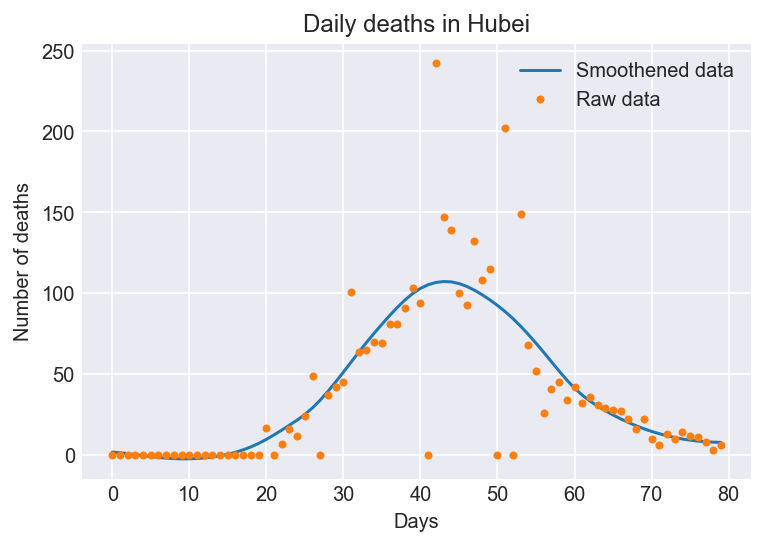

In [681]:
# Get mob data
df_global = pd.read_csv("time_series_covid19_deaths_global.csv")
df_hubei = df_global[df_global["Province/State"] == "Hubei"]
date_format = "%-m/%-d/%y"
start_date_global = datetime.date(2020, 1, 22)
end_date_global = datetime.date(2020, 5, 27)

data_hubei = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_hubei.append(df_hubei[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)
    
data_hubei[1:] = np.diff(data_hubei)
data_hubei = data_hubei[:60]
smooth_data_hubei = np.concatenate((np.zeros(20), data_hubei))
smooth_data_hubei = smoothen(savgol_filter(smooth_data_hubei, 37, 3), 2)

plt.plot(smooth_data_hubei, label="Smoothened data")
plt.plot(np.concatenate((np.zeros(20), data_hubei)), '.', label="Raw data")
plt.title("Daily deaths in Hubei")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

Optimization terminated successfully.1.2e-04 2.7e+00] conv: 1.008e+00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.6.8e-04 3.0e+00] conv: 1.075e+00
Optimization terminated successfully.2.0e-03 3.0e+00] conv: 1.021e+00


Breakpoint        Loss     offset         pop    I_init     T_inf  gamma_x  \
0        40.0  397.645135  20.265836  58500000.0  0.000001  7.000000  0.00012   
0        50.0  372.014143  20.420292  58500000.0  0.000017  5.000000  0.00200   
0        60.0  313.275283  20.686778  58500000.0  0.000100  6.078421  0.00200   

      R_max  R_min  sd_offset  
0  2.600000   0.95  22.204029  
0  3.000000   0.95  20.299156  
0  2.975437   0.95  20.338223

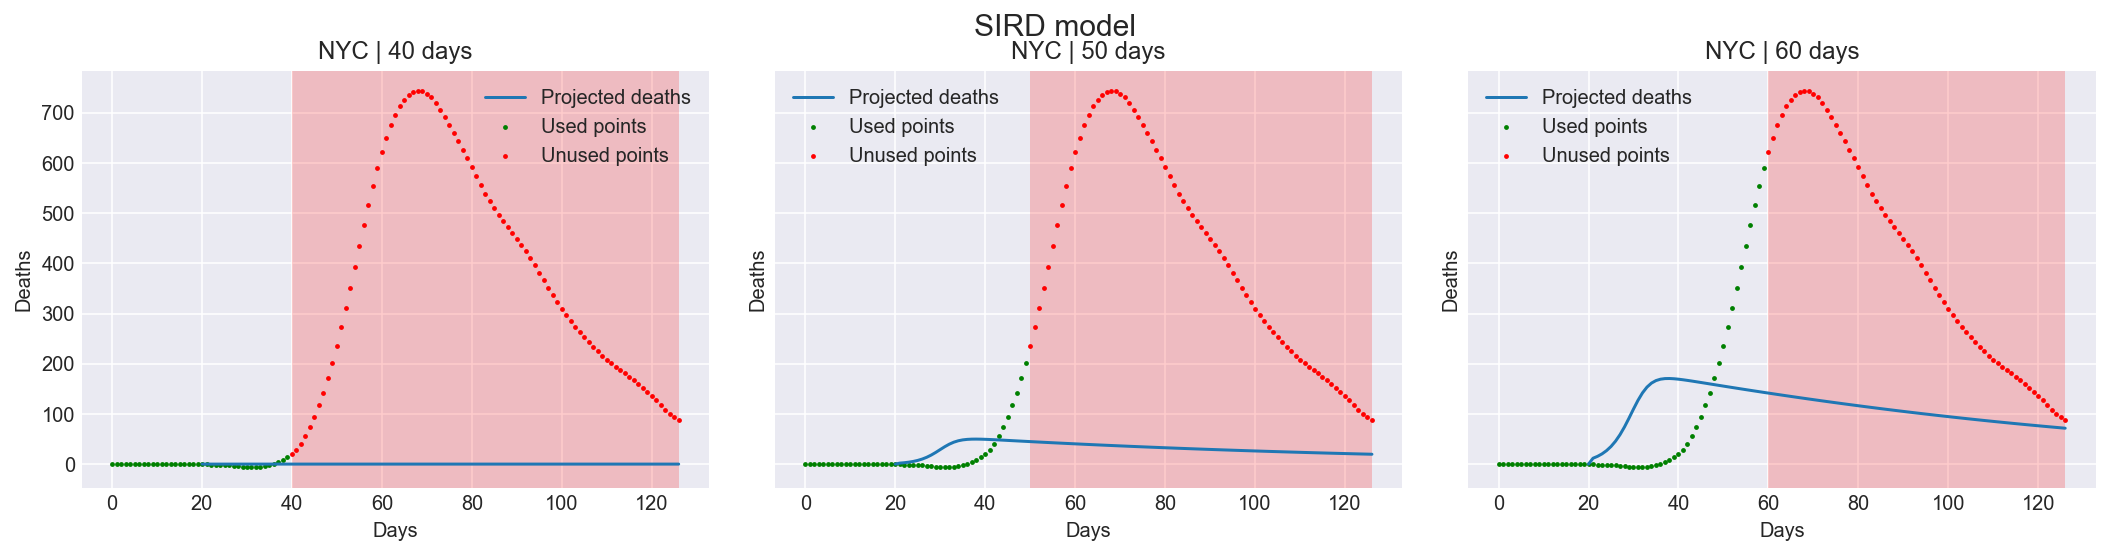

In [783]:
# Since mobility data is not available we construct our own
padded_sd = -500 * expit(np.arange(-50, 60, 1) / 2)
get_model_stats(sird_sd, rmse_loss, smooth_data_hubei, [40, 50, 60], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                bounds=[(20, 35), (5.85e7, 5.85e7), (1e-6, 1e-4), (5.0, 7.0), (1.2e-4, 2e-3), (2.6, 3.0), (0.85, 0.95), (20, 23)])

Conclusion: Lockdown strategies which decrease $R$ significantly lead to a decrease in the number of deaths. However, as long as infections remain, re-opening is risky. Further, the $R$ pre-lockdown controls the rate of rise of disease upto the peak and $R$ post lockdown controls how fast we come down from the peak

<h2>Italy</h2>

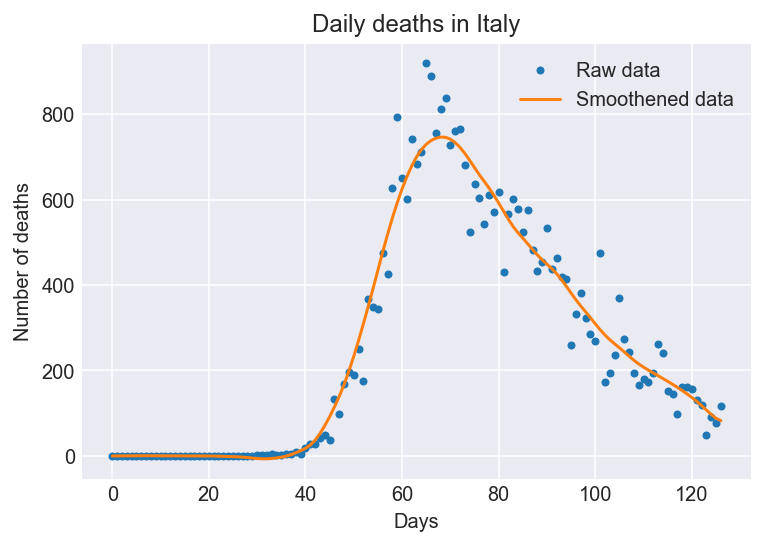

In [1172]:
# Get the death data
df_italy = df_global[df_global["Country/Region"] == "Italy"]

data_italy = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_italy.append(df_italy[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)
    
data_italy[1:] = np.diff(data_italy)
smooth_data_italy = smoothen(smoothen(savgol_filter(data_italy, 37, 3), 1), 1)

plt.plot(data_italy, '.', label="Raw data")
plt.plot(smooth_data_italy, label="Smoothened data")
plt.title("Daily deaths in Italy")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

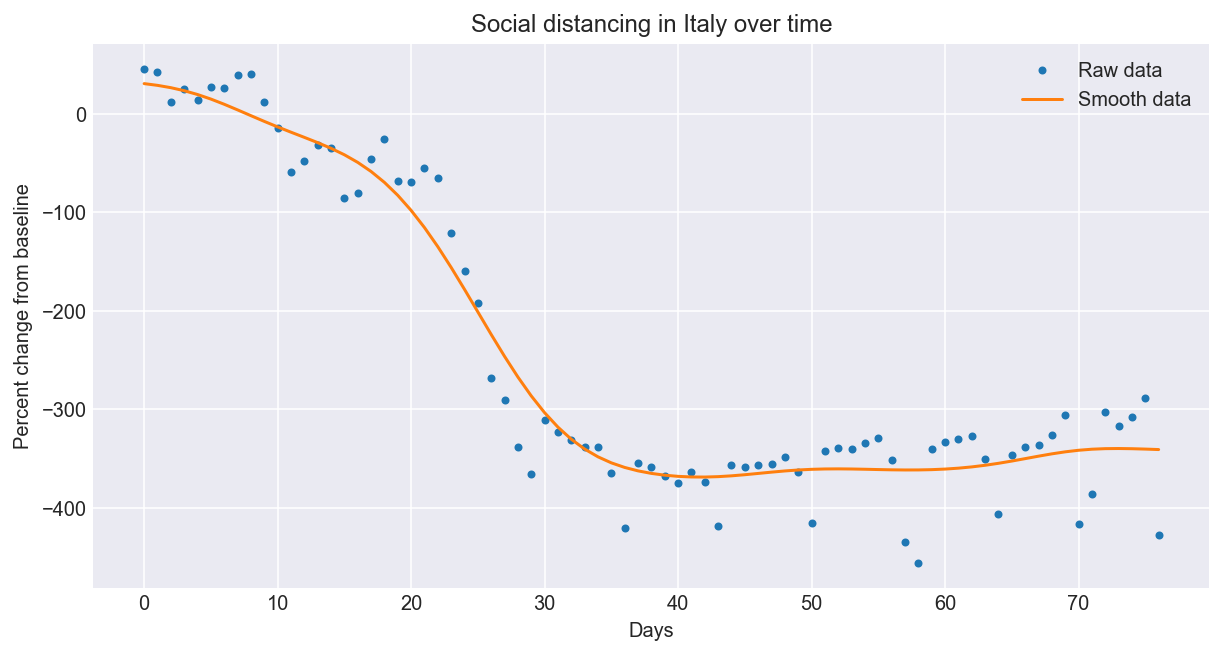

In [1191]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv")
df_sd = df_sd[df_sd['country_region_code'] == 'IT']
df_sd = df_sd[pd.isnull(df_sd['sub_region_1'])]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_italy = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_italy.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_italy = np.array(agg_sd_italy)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_italy, '.', label="Raw data")
agg_sd_italy = smoothen(smoothen(savgol_filter(agg_sd_italy, 37, 6), 3), 3)
plt.plot(agg_sd_italy, label="Smooth data")
plt.title("Social distancing in Italy over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.022e+00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.011e+00
Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.109e+00
Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.030e+00
Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.278e+00
Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.101e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.094e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.246e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.895e+00


Breakpoint        Loss     offset         pop    I_init  T_inf  gamma_x  \
0        40.0  336.185043  34.762564  60400000.0  0.000011    5.0   0.0016   
0        43.0  188.068318  24.942659  60400000.0  0.000010    5.0   0.0016   
0        46.0  627.193869  22.634620  60400000.0  0.000010    5.0   0.0016   
0        49.0  642.369545  21.442187  60400000.0  0.000010    5.0   0.0016   
0        52.0  678.541325  21.907799  60400000.0  0.000010    5.0   0.0016   
0        55.0  272.247976  21.415690  60400000.0  0.000010    5.0   0.0016   
0        58.0  177.760909  20.100702  60400000.0  0.000011    5.0   0.0016   
0       100.0   54.354468  20.618657  60400000.0  0.000011    5.0   0.0016   
0       120.0   52.697083  20.589273  60400000.0  0.000011    5.0   0.0016   

      R_max     R_min  sd_offset  
0  2.100000  0.827088  21.860889  
0  2.082606  0.823846  20.492710  
0  2.100000  0.900000  20.319186  
0  2.093194  0.863553  20.320657  
0  2.096015  0.872378  20.505040  
0  2.095667  0.800100  22.805349  
0  2.024204  0.801970  22.054493  
0  1.960277  0.808080  22.682962  
0  1.954449  0.825126  22.490631

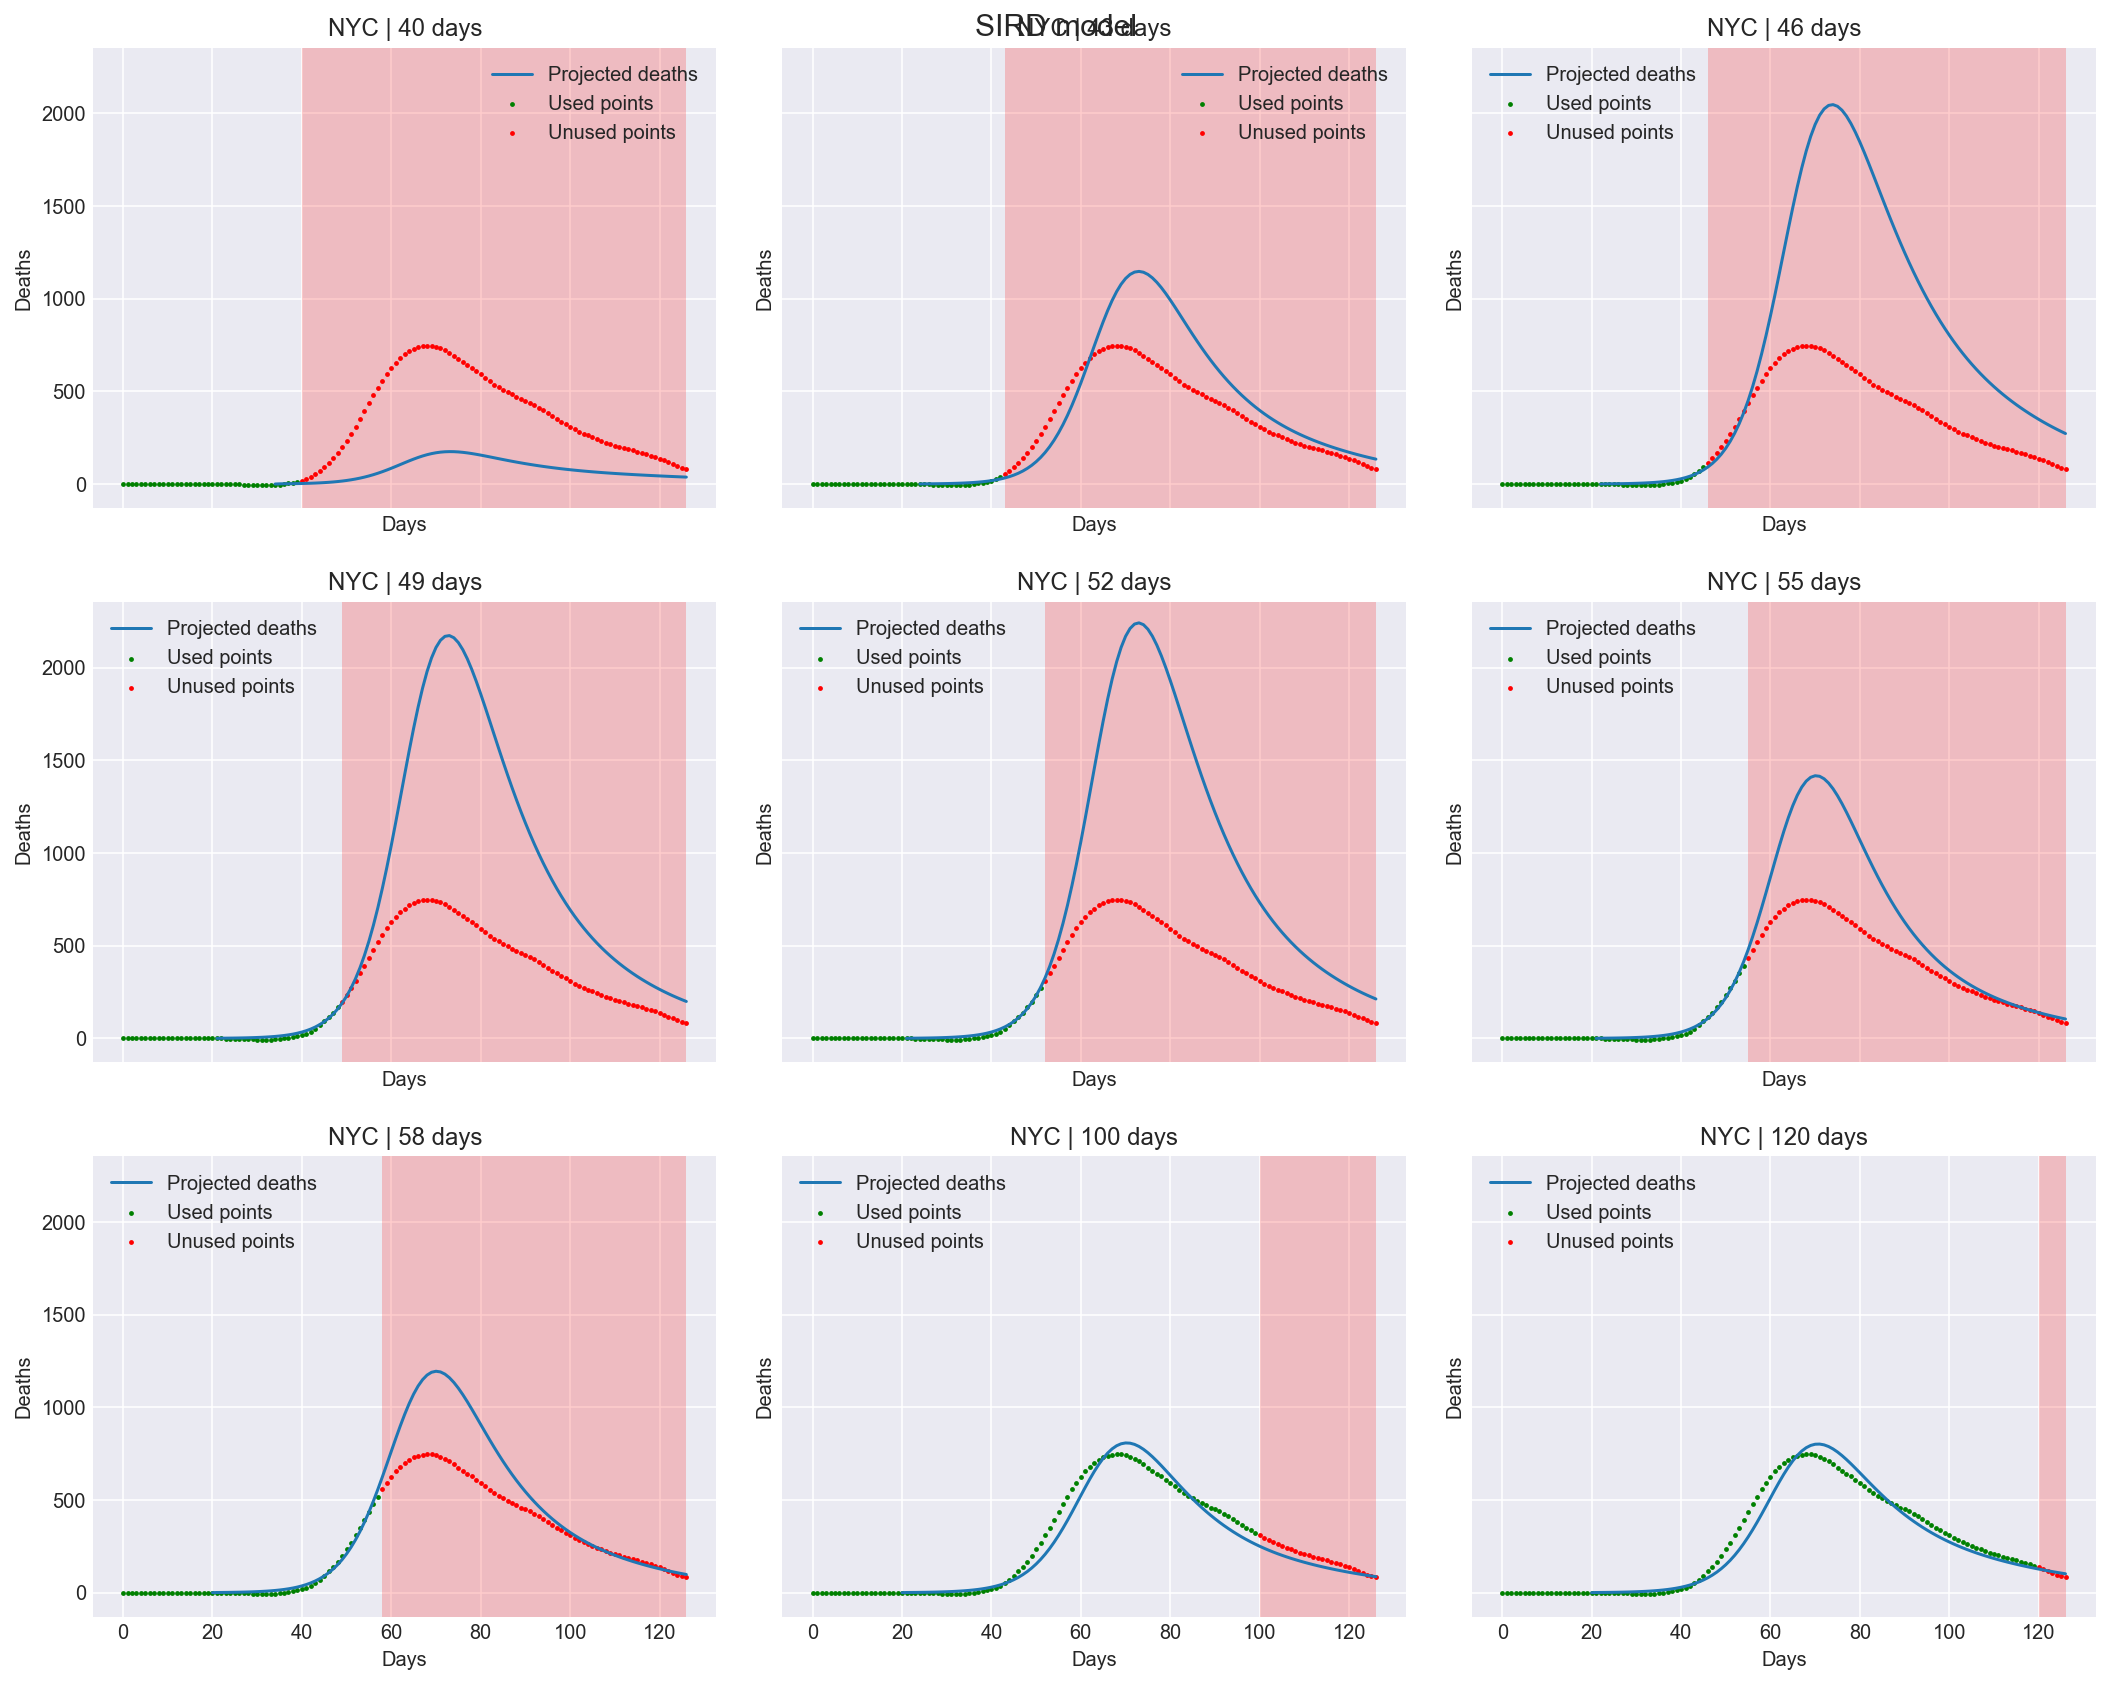

In [1042]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_italy[0], agg_sd_italy)) 

# Aggressive quarantining and testing lead to a lower value for R
get_model_stats(sird_sd, rmse_loss, smooth_data_italy, list(range(40, 60, 3)) + [100, 120], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                bounds=[(20, 35), (6.04e7, 6.04e7), (1e-5, 1.1e-5), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.1), (0.80, 0.90), (20, 23)])

<h2>Germany</h2>

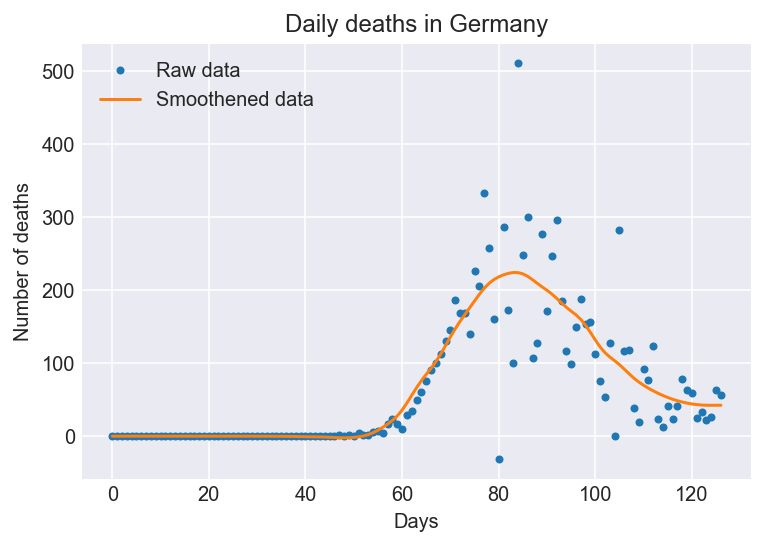

In [1043]:
# Get the death data
df_germany = df_global[df_global["Country/Region"] == "Germany"]

data_germany = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_germany.append(df_germany[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)
    
data_germany[1:] = np.diff(data_germany)
smooth_data_germany = smoothen(smoothen(smoothen(savgol_filter(data_germany, 37, 3), 1), 1), 1)

plt.plot(data_germany, '.', label="Raw data")
plt.plot(smooth_data_germany, label="Smoothened data")
plt.title("Daily deaths in Germany")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

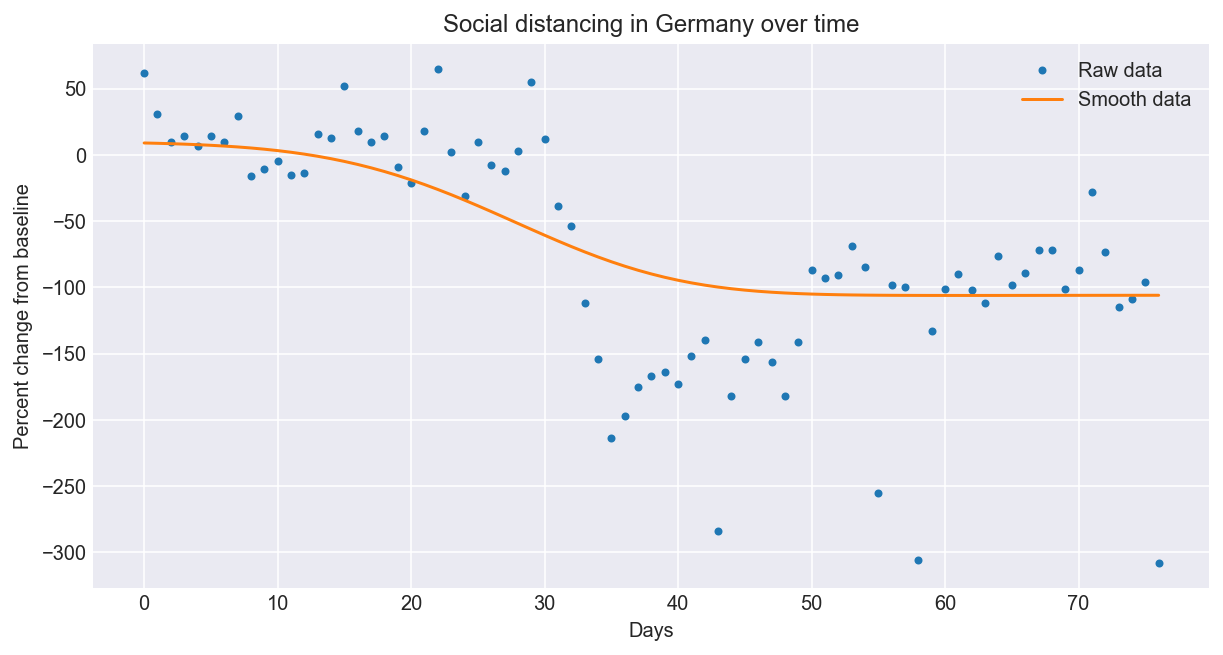

In [1035]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd['country_region_code'] == 'DE']
df_sd = df_sd[pd.isnull(df_sd['sub_region_1'])]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_germany = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_germany.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_germany = np.array(agg_sd_germany)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_germany, '.', label="Raw data")
agg_sd_germany = smoothen(smoothen(agg_sd_germany, 6), 6)
agg_sd_germany = np.maximum(np.ones_like(agg_sd_germany) * agg_sd_germany[-1], agg_sd_germany)
agg_sd_germany = smoothen(smoothen(agg_sd_germany, 6), 6)
plt.plot(agg_sd_germany, label="Smooth data")
plt.title("Social distancing in Germany over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.080e+00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.018e+00
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.522e+00
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 5.265e+00
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 4.632e+00
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.085e+00
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 2.920e+01
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.582e+00
Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.473e+00


Breakpoint       Loss     offset         pop    I_init  T_inf  gamma_x  \
0        60.0  56.267966  43.982056  83000000.0  0.000008    5.0   0.0016   
0        63.0  43.946772  42.757114  83000000.0  0.000008    5.0   0.0016   
0        66.0  38.913570  41.230231  83000000.0  0.000008    5.0   0.0016   
0        69.0  38.958926  41.621785  83000000.0  0.000008    5.0   0.0016   
0        72.0  38.958926  41.159348  83000000.0  0.000008    5.0   0.0016   
0        75.0  39.965504  40.682205  83000000.0  0.000008    5.0   0.0016   
0        78.0  41.602651  40.741134  83000000.0  0.000008    5.0   0.0016   
0       100.0  43.975993  40.475959  83000000.0  0.000008    5.0   0.0016   
0       120.0  22.959041  39.484662  83000000.0  0.000008    5.0   0.0016   

      R_max     R_min  sd_offset  
0  2.300000  0.950000       23.0  
0  2.300000  0.950000       23.0  
0  2.300000  0.950000       23.0  
0  2.300000  0.950000       23.0  
0  2.300000  0.950000       23.0  
0  2.257838  0.949959       23.0  
0  2.267530  0.950000       23.0  
0  2.286043  0.946916       23.0  
0  2.280636  0.875034       23.0

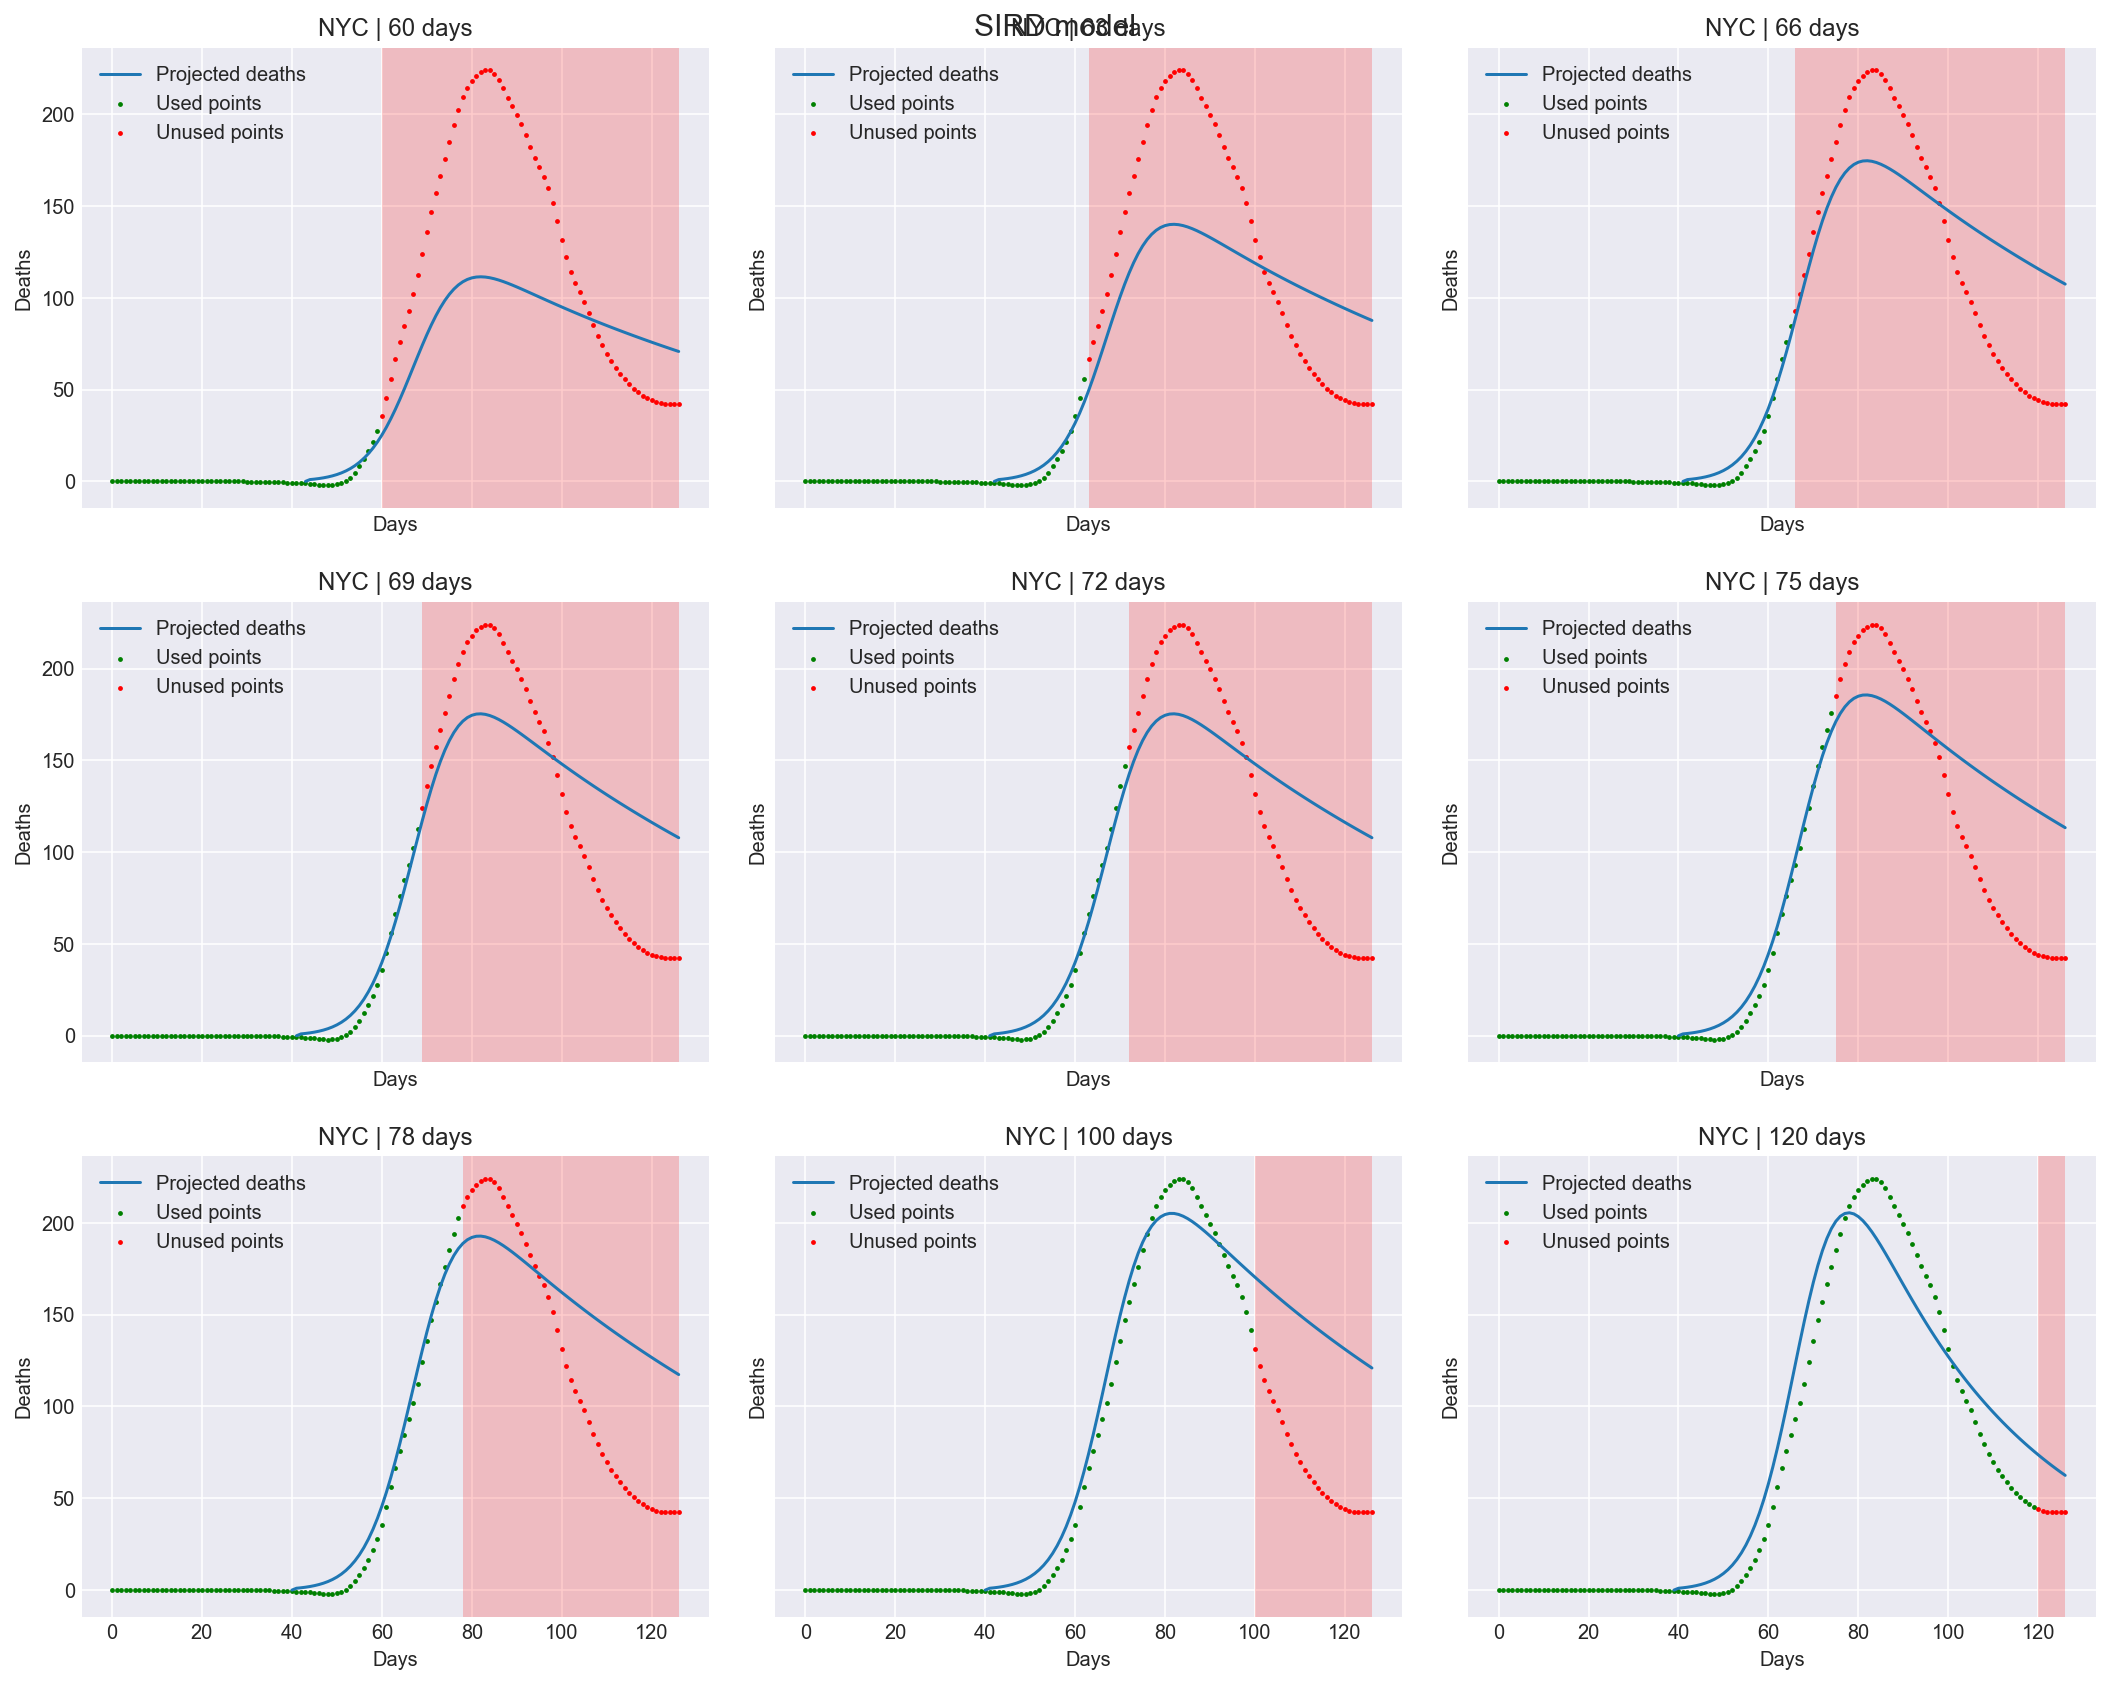

In [1038]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_germany[0], agg_sd_germany)) 

get_model_stats(sird_sd, rmse_loss, smooth_data_germany, list(range(60, 80, 3)) + [100, 120], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                bounds=[(30, 50), (8.3e7, 8.3e7), (7.5e-6, 7.53e-6), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.3), (0.80, 0.95), (23, 23)])

<h2>California</h2>

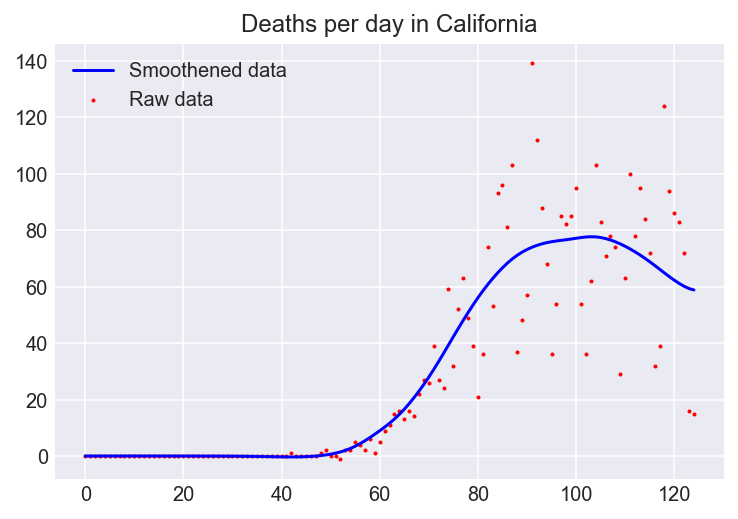

In [850]:
# Fetch data for California
raw_data_us = pd.read_csv("time_series_covid19_deaths_US.csv")
start_date = datetime.date(2020, 1, 22)
date_format = "%-m/%-d/%y"

# Extract NYC time_series data
deaths_time_series_cali = []
date = deepcopy(start_date)
df_cali = raw_data_us[raw_data_us['Combined_Key'].str.contains("California")]
df_cali_cols = df_nyc.columns.values

while date.strftime(date_format) in df_nyc_cols:
    deaths_time_series_cali.append(np.sum(df_cali[date.strftime(date_format)].values))
    date = date + datetime.timedelta(days=1)

deaths_time_series_cali = np.array(deaths_time_series_cali)
deaths_time_series_cali[1:] = np.diff(deaths_time_series_cali)

# Data visualization
smooth_data_cali = smoothen(smoothen(savgol_filter(deaths_time_series_cali, 45, 3), 3), 1)

plt.scatter(np.arange(smooth_data_cali.shape[0]), deaths_time_series_cali, label="Raw data", s=1, c='red')
plt.plot(smooth_data_cali, label="Smoothened data", c='blue')
plt.legend()
plt.title("Deaths per day in California")
plt.show()

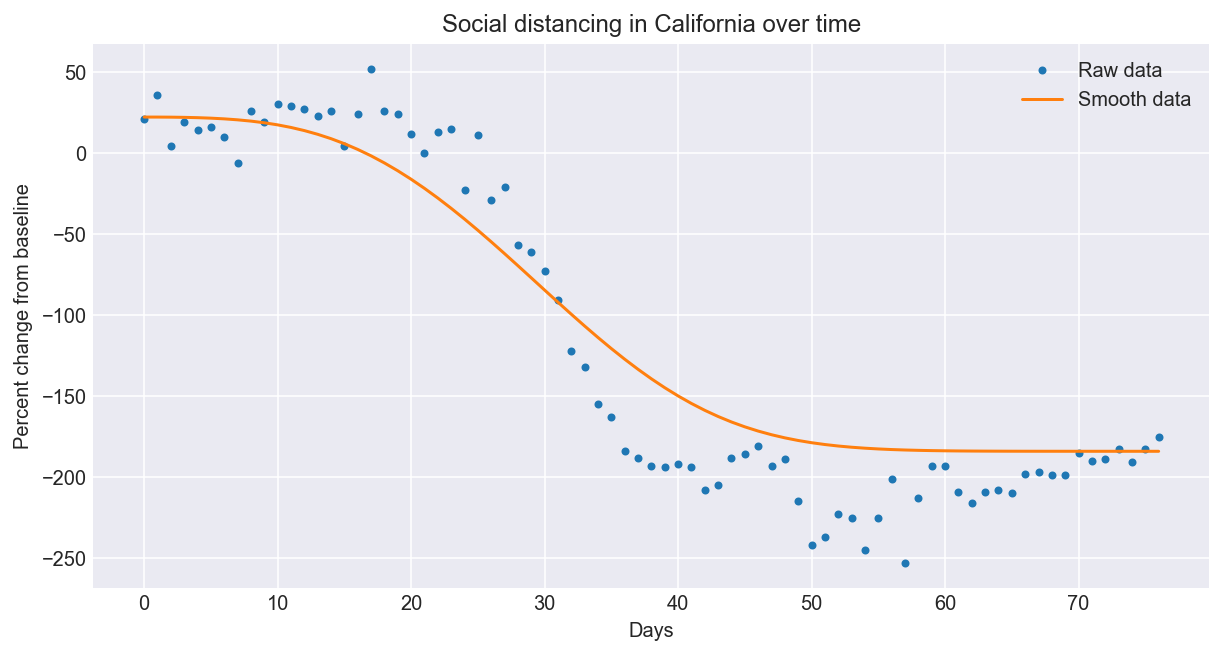

In [860]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd['country_region_code'] == 'US']
df_sd = df_sd[df_sd["sub_region_1"] == "California"]


categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_cali = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_cali.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_cali = np.array(agg_sd_cali)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_cali, '.', label="Raw data")
agg_sd_cali = smoothen(smoothen(savgol_filter(agg_sd_cali, 45, 3), 3), 1)
agg_sd_cali = np.maximum(np.ones_like(agg_sd_cali) * agg_sd_cali[-1], agg_sd_cali)
agg_sd_cali = smoothen(smoothen(agg_sd_cali, 6), 6)
plt.plot(agg_sd_cali, label="Smooth data")
plt.title("Social distancing in California over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

Optimization terminated successfully.1.6e-03 2.3e+00] conv: 1.122e+00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.1.6e-03 2.2e+00] conv: 2.111e+00
Optimization terminated successfully.1.6e-03 2.2e+00] conv: 3.278e+02
Optimization terminated successfully.1.6e-03 2.2e+00] conv: 7.259e+01
Optimization terminated successfully.1.6e-03 2.2e+00] conv: 3.690e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 3.517e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.627e+00
Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.532e+00
Optimization terminated successfully.1.6e-03 2.1e+00] conv: 1.157e+00


Breakpoint       Loss     offset         pop    I_init  T_inf  gamma_x  \
0        60.0  37.156286  49.323105  39500000.0  0.000017    5.0   0.0016   
0        63.0  38.066503  48.952155  39500000.0  0.000017    5.0   0.0016   
0        66.0  39.167475  48.272998  39500000.0  0.000017    5.0   0.0016   
0        69.0  39.485261  48.945224  39500000.0  0.000017    5.0   0.0016   
0        72.0  34.572578  48.242163  39500000.0  0.000017    5.0   0.0016   
0        75.0  15.285628  47.477643  39500000.0  0.000017    5.0   0.0016   
0        78.0   9.459085  47.229392  39500000.0  0.000017    5.0   0.0016   
0       100.0   3.825527  49.811821  39500000.0  0.000017    5.0   0.0016   
0       125.0   3.652416  49.484544  39500000.0  0.000017    5.0   0.0016   

      R_max     R_min  sd_offset  
0  2.300000  0.990000  20.787400  
0  2.200758  0.800007  22.406322  
0  2.178205  0.800000  22.236440  
0  2.171533  0.800001  22.227012  
0  2.161786  0.854694  22.613465  
0  1.997186  0.964615  20.927617  
0  1.994102  0.989956  20.117188  
0  2.140513  0.990000  20.074578  
0  2.146611  0.989996  20.463393

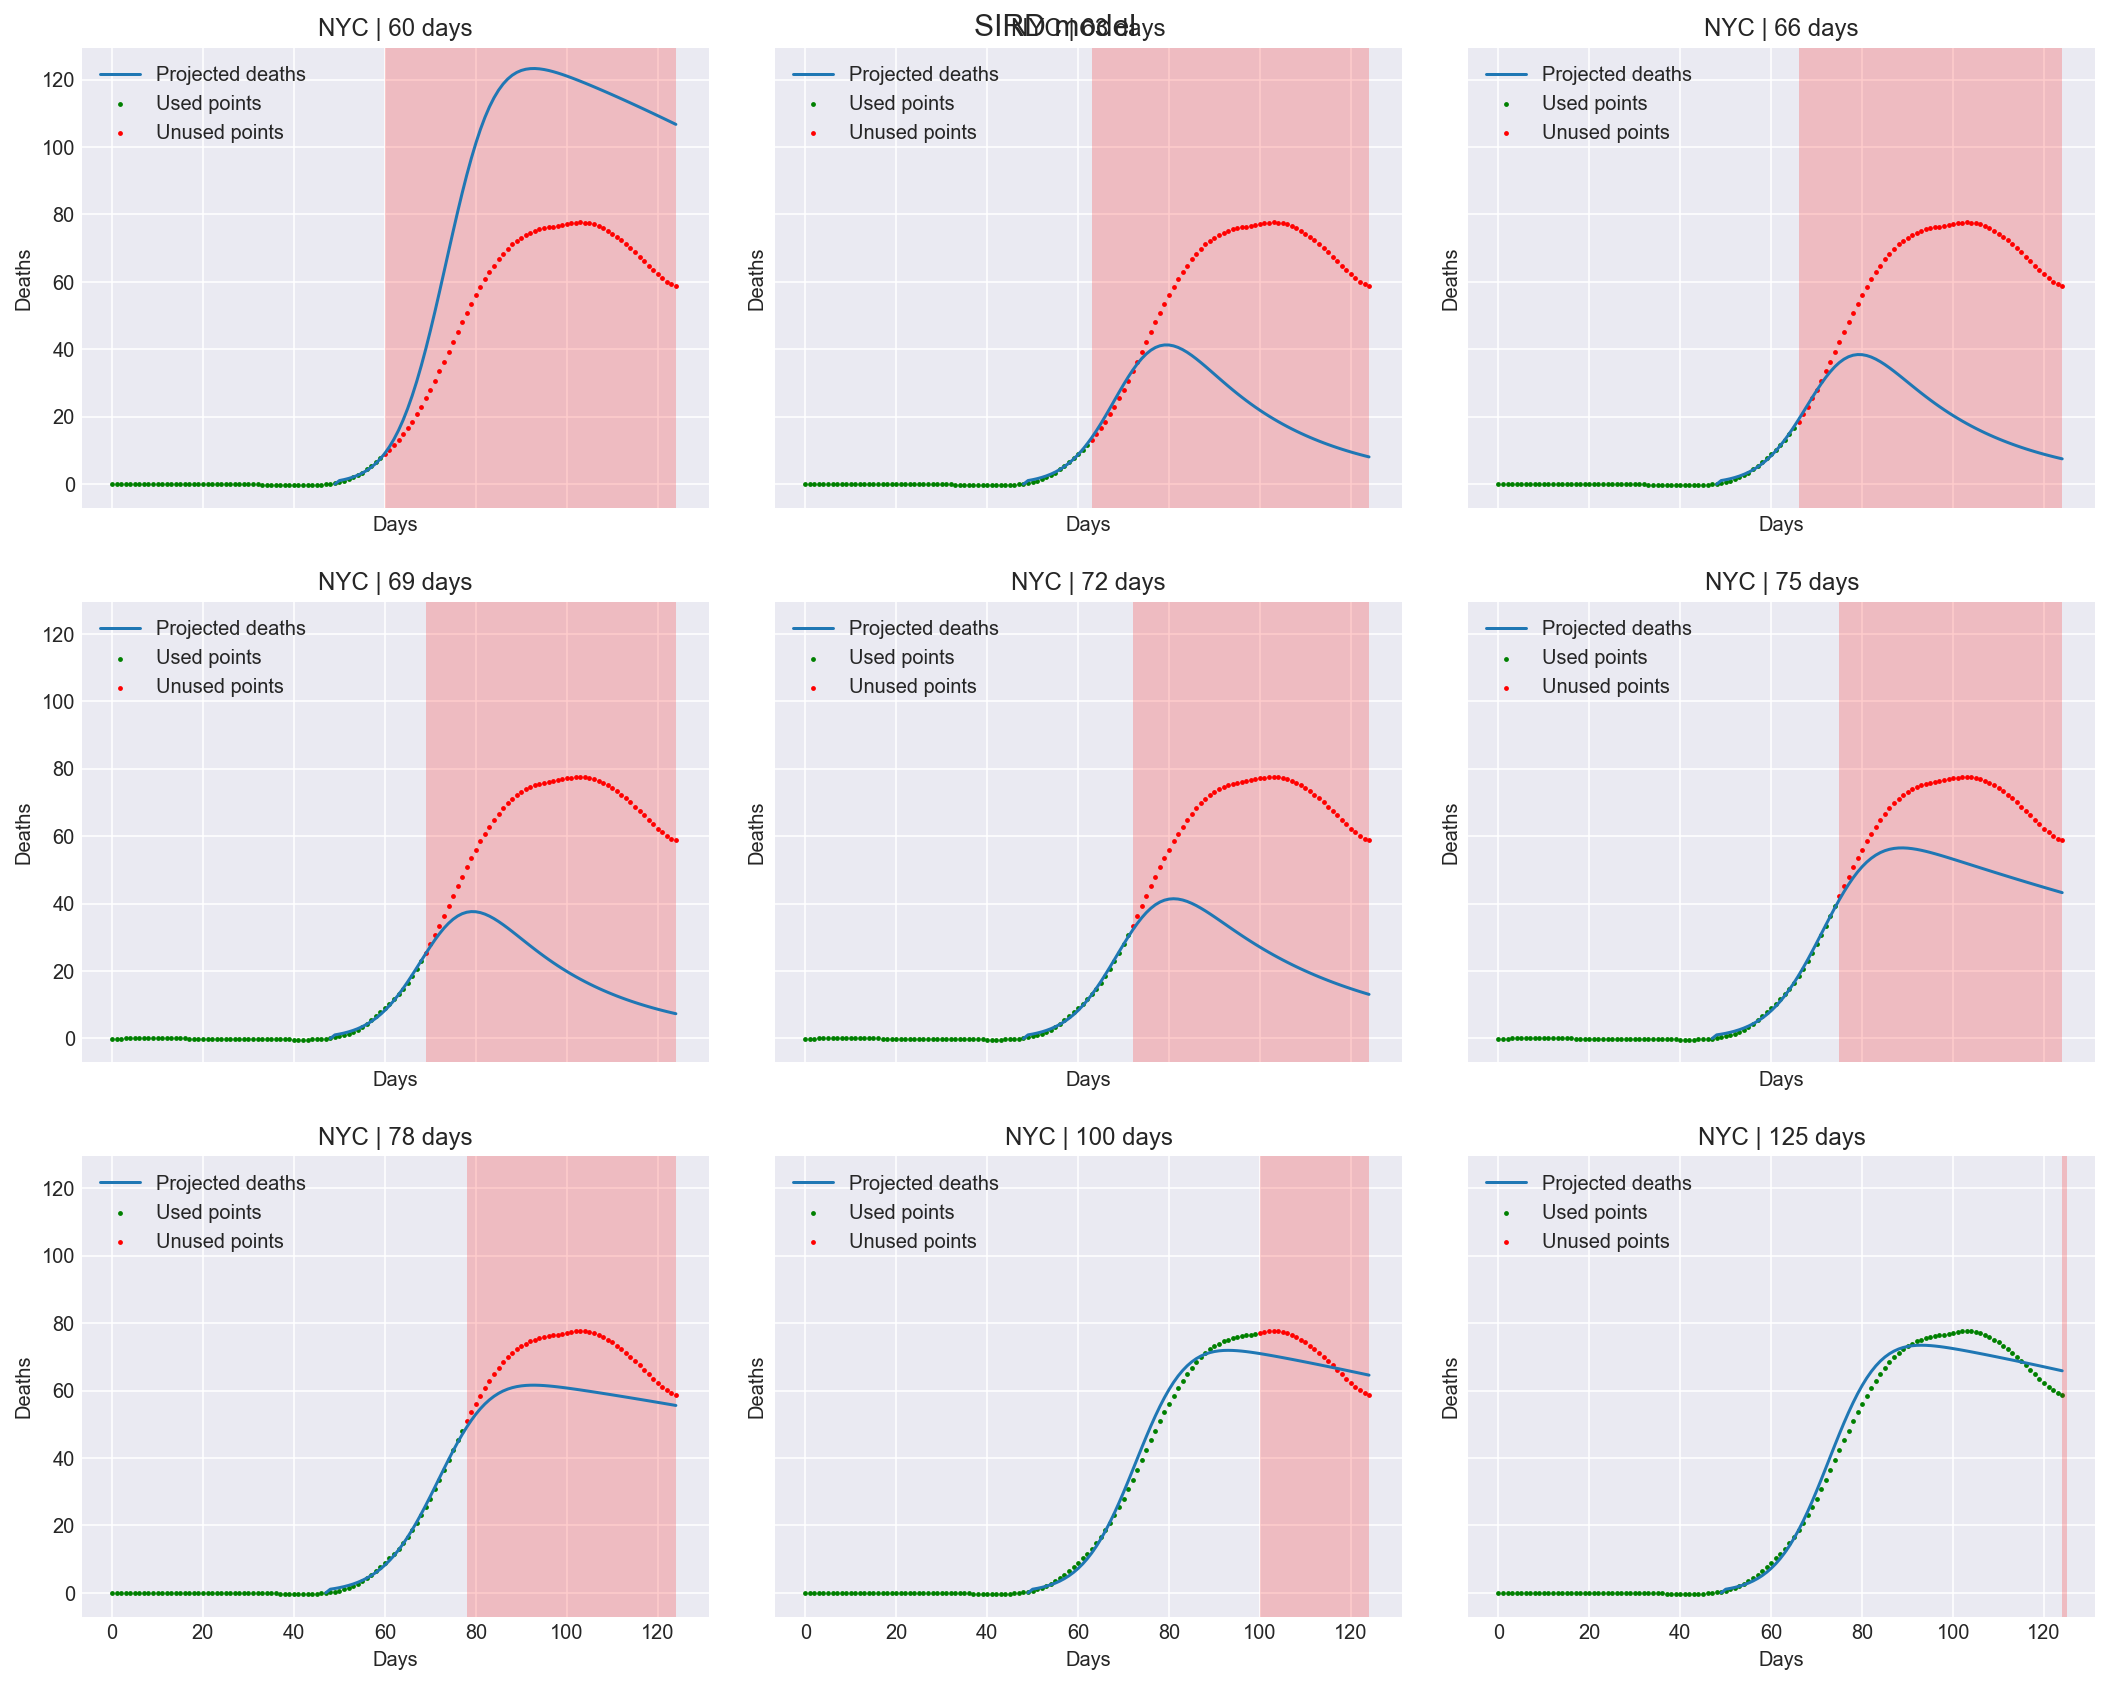

In [1033]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_cali[0], agg_sd_cali)) 

get_model_stats(sird_sd, rmse_loss, smooth_data_cali, list(range(60, 80, 3)) + [100, smooth_data_cali.shape[0]], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                bounds=[(30, 50), (3.95e7, 3.95e7), (1.7e-5, 1.7e-5), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.3), (0.80, 0.99), (20, 23)])

<h2>Spain</h2>

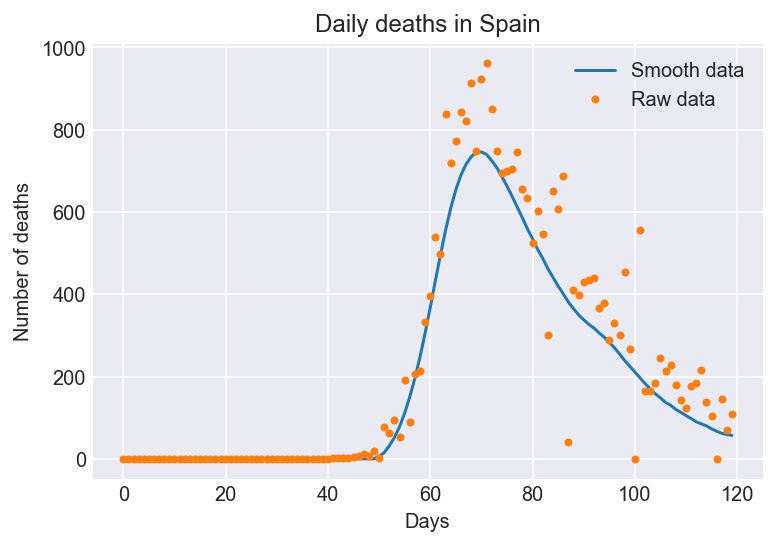

In [1134]:
# Get the death data
df_spain = df_global[df_global["Country/Region"] == "Spain"]

data_spain = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_spain.append(df_spain[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)

data_spain = data_spain[:120]
data_spain[1:] = np.diff(data_spain)
smooth_data_spain = deepcopy(data_spain)

for i in range(1, 15):
    smooth_data_spain = smoothen(smooth_data_spain, 1)

plt.plot(smooth_data_spain, label="Smooth data")
plt.plot(data_spain, '.', label="Raw data")
# plt.plot(smooth_data_spain, label="Smoothened data")
plt.title("Daily deaths in Spain")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

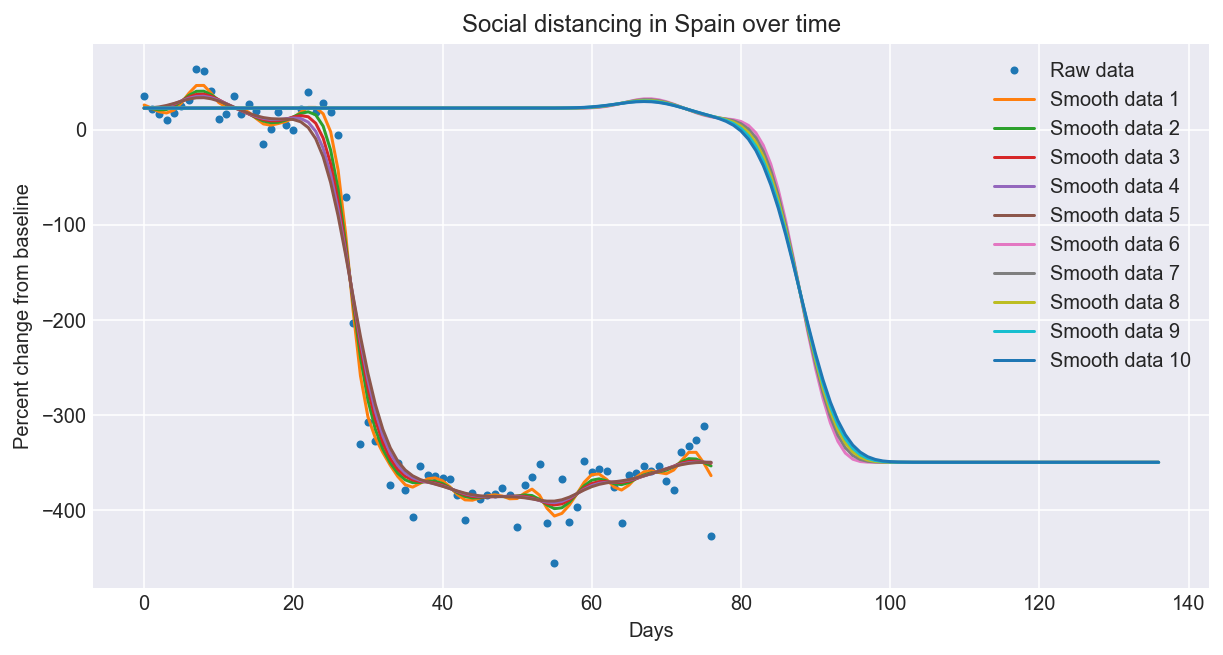

In [1027]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd['country_region_code'] == 'ES']
df_sd = df_sd[pd.isnull(df_sd['sub_region_1'])]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_spain = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_spain.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_spain = np.array(agg_sd_spain)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_spain, '.', label="Raw data")

for i in range(5):
    agg_sd_spain = smoothen(smoothen(agg_sd_spain, 1), 1)
    plt.plot(agg_sd_spain, label="Smooth data {}".format(i + 1))

agg_sd_spain = np.maximum(np.ones_like(agg_sd_spain) * agg_sd_spain[-1], agg_sd_spain)
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_spain[0], agg_sd_spain)) 

for i in range(5):
    padded_sd = smoothen(smoothen(padded_sd, 1), 1)
    plt.plot(padded_sd, label="Smooth data {}".format(i + 6))

plt.title("Social distancing in Spain over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

Optimization terminated successfully.1.6e-03 1.8e+00] conv: 1.051e+00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.1.6e-03 1.9e+00] conv: 4.869e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.412e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.840e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.648e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.009e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.257e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.085e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.063e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.051e+00
Optimization terminated successfully.1.6e-03 2.0e+00] conv: 1.378e+00


Breakpoint        Loss  offset         pop    I_init  T_inf  gamma_x  \
0        55.0  252.990576    25.0  46900000.0  0.000013    5.0   0.0016   
0        58.0  124.177617    25.0  46900000.0  0.000013    5.0   0.0016   
0        61.0   68.136456    25.0  46900000.0  0.000013    5.0   0.0016   
0        64.0   84.914174    25.0  46900000.0  0.000013    5.0   0.0016   
0        67.0   88.353475    25.0  46900000.0  0.000013    5.0   0.0016   
0        70.0   53.843629    25.0  46900000.0  0.000013    5.0   0.0016   
0        73.0   31.556875    25.0  46900000.0  0.000013    5.0   0.0016   
0        76.0   31.911358    25.0  46900000.0  0.000013    5.0   0.0016   
0        79.0   30.297284    25.0  46900000.0  0.000013    5.0   0.0016   
0       100.0   25.143750    25.0  46900000.0  0.000013    5.0   0.0016   
0       120.0   23.708759    25.0  46900000.0  0.000013    5.0   0.0016   

      R_max     R_min  sd_offset  
0  1.800000  0.750000       23.0  
0  1.891299  0.899246       23.0  
0  1.955841  0.899571       23.0  
0  1.977467  0.899795       23.0  
0  1.979862  0.899918       23.0  
0  1.979784  0.871394       23.0  
0  1.981786  0.844434       23.0  
0  1.981673  0.845060       23.0  
0  1.982062  0.842227       23.0  
0  1.984143  0.829474       23.0  
0  1.987278  0.817847       23.0

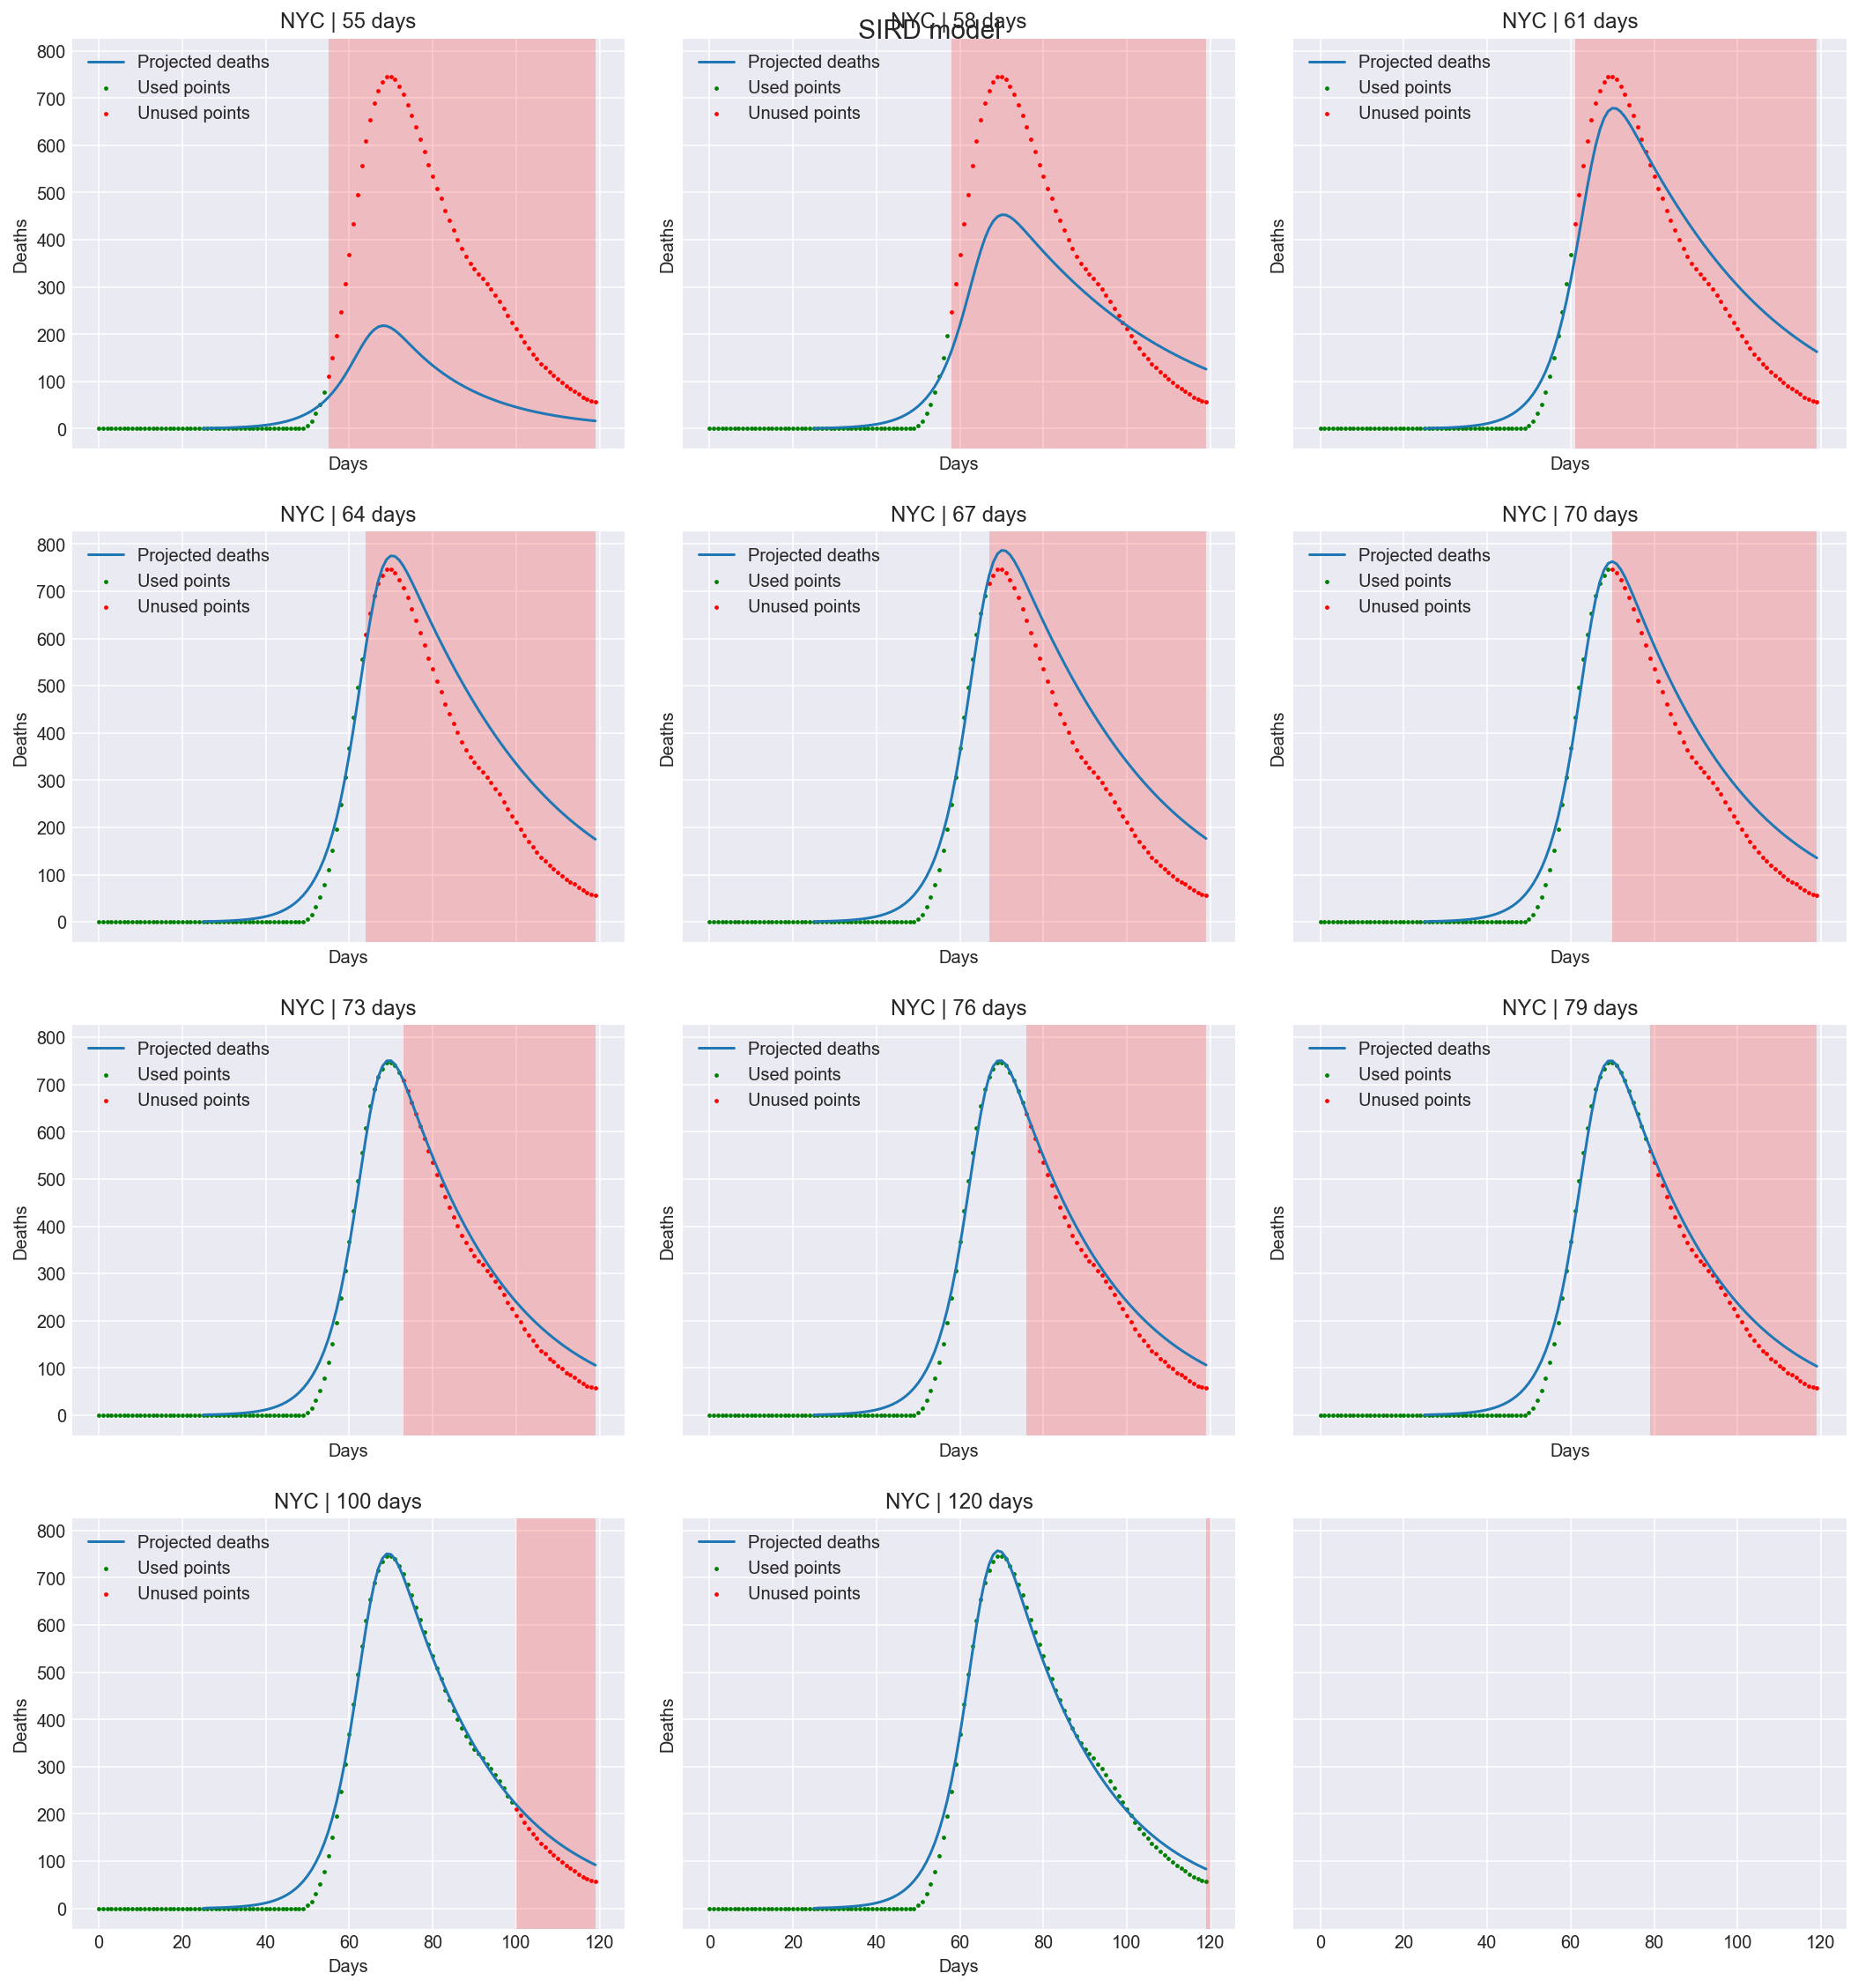

In [1028]:
# Get model stats
# pad_sd = 60 # How many days to pad the social distancing data by 
# padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_spain[0], agg_sd_spain)) 

get_model_stats(sird_sd, rmse_loss, smooth_data_spain, list(range(55, 80, 3)) + [100, smooth_data_spain.shape[0]], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                bounds=[(25, 25), (4.69e7, 4.69e7), (1.3e-5, 1.3e-5), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.2), (0.75, 0.90), (23, 23)])


<h1>Death to infection ratio</h1>

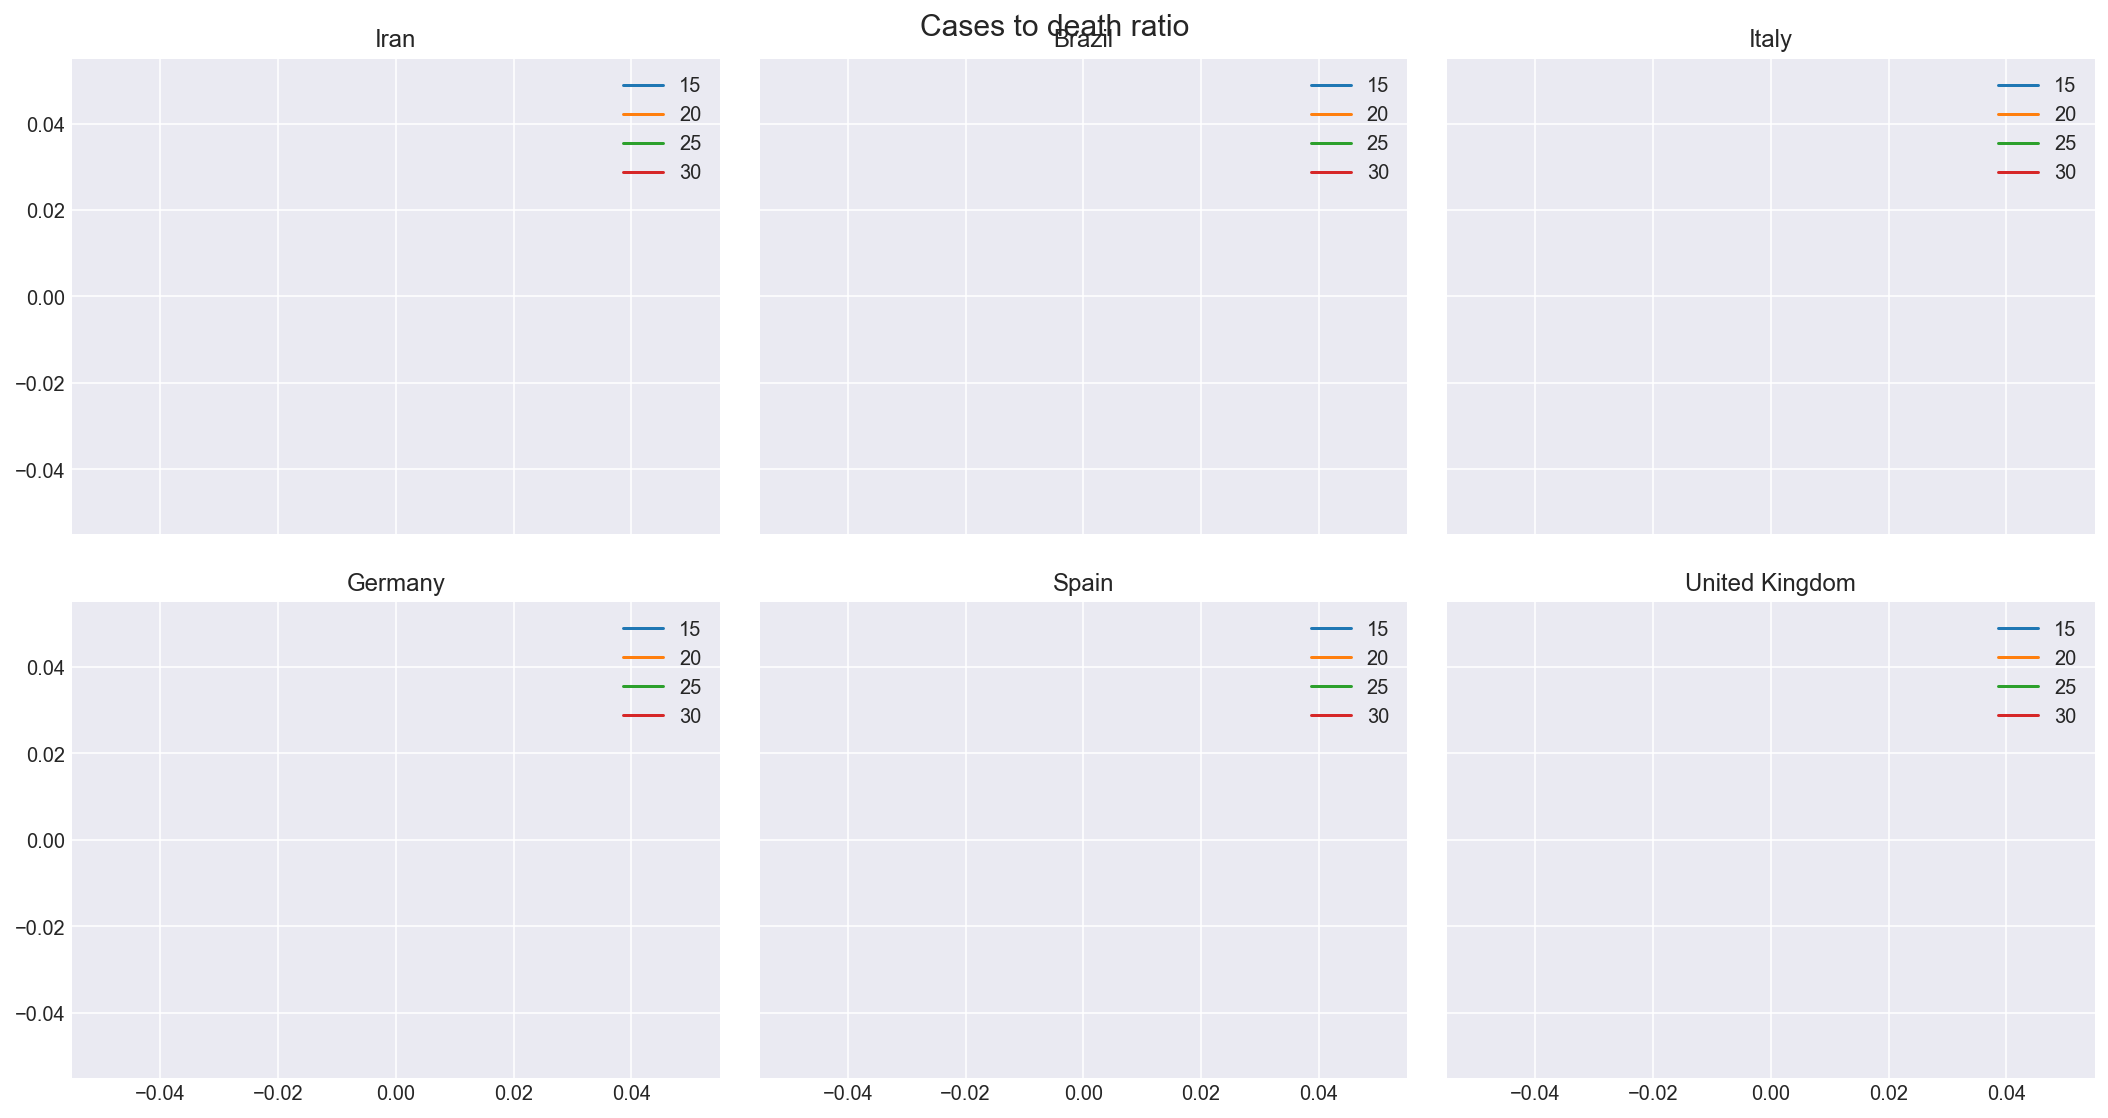

In [1025]:
# Plots 
df_global_inf = pd.read_csv("time_series_covid19_confirmed_global.csv")

fig, axs = plt.subplots(2, 3, figsize=(15, 4 * 2), sharex=True, sharey=True)
countries = ["Iran", "Brazil", "Italy", "Germany", "Spain", "United Kingdom"]

for country, ax in zip(countries, axs.flat):
    df_spain = df_global[df_global["Country/Region"] == country]
    df_spain_inf = df_global_inf[df_global_inf["Country/Region"] == country]

    data_spain = []
    data_spain_inf = []

    curr_date = deepcopy(start_date_global)
    while curr_date <= end_date_global:
        data_spain.append(df_spain[curr_date.strftime(date_format)].iloc[0])
        data_spain_inf.append(df_spain_inf[curr_date.strftime(date_format)].iloc[0])
        curr_date = curr_date + datetime.timedelta(days=1)

    data_spain = np.array(data_spain)[120:]
    data_spain_inf = np.array(data_spain_inf)[120:]
    data_spain[1:] = np.diff(data_spain)
    data_spain_inf[1:] = np.diff(data_spain_inf)

    smooth_data_spain = deepcopy(data_spain)
    smooth_data_spain_inf = deepcopy(data_spain_inf)

    for i in range(1, 3):
        smooth_data_spain = smoothen(smooth_data_spain, 1)
        smooth_data_spain_inf = smoothen(smooth_data_spain_inf, 1)
        
    for offset in [15, 20, 25, 30]:
        smooth_data_spain_ = smooth_data_spain[offset:]
        smooth_data_spain_inf_ = smooth_data_spain_inf[:-offset]
        ax.plot(smoothen(smooth_data_spain_inf_/(smooth_data_spain_ + 1), 6), label=offset)
        
    ax.set_title(country)
    ax.legend()

fig.suptitle("Cases to death ratio", fontsize=15)
fig.tight_layout(pad=2.0)

<h1>Uncertainty Analysis</h1>

In [1261]:
def get_model_stats_v2(model, loss_fun, data, breakpoints, plot_title, 
                       fixed_params, var_param_vals, param_order, loss_factor, future_preds=0, huge=False):
    
    df = pd.DataFrame()
    df['Breakpoint'] = []
    df['Train Loss'] = []
    
    for col in list(fixed_params.keys()) + list(var_param_vals.keys()):
        df[col] = []
    
    time_values = np.arange(data.shape[0])
    
    col_num = 3
    row_num = ceil(len(breakpoints) / col_num)
    
    if not huge:
        fig, axs = plt.subplots(row_num, col_num, figsize=(15, 4 * row_num), sharex=True, sharey=True)
    else:
        col_num = 2
        row_num = ceil(len(breakpoints) / col_num)
        fig, axs = plt.subplots(ceil(len(breakpoints) / 2), 2, figsize=(15, 8 * row_num), sharex=True, sharey=True)
        
    var_param_list = list(var_param_vals.keys())
    
    for b, ax in zip(breakpoints, axs.flat):
        min_loss = np.inf
        best_preds = None
        best_offset = None
        best_params = None
        all_preds = []
        
        for vals in product(*var_param_vals.values()):
            # Run the model, get loss and preds
            t_max = data[:b].shape[0] - 1
            
            params = []
            for x in param_order:
                if x in fixed_params:
                    params.append(fixed_params[x])
                elif x in var_param_vals:
                    params.append(vals[var_param_list.index(x)])
            
            loss, _ = run_model(params, model, loss_fun, data[:b], return_preds=True)
            _, preds = run_model(params, model, loss_fun, np.concatenate((data, np.zeros(future_preds))), return_preds=True)
            
            if "offset" in fixed_params:
                offset = fixed_params["offset"]
            elif "offset" in var_param_vals:
                offset = vals[var_param_list.index("offset")]
            
            if loss < min_loss:
                min_loss = loss
                best_preds = preds
                best_offset = offset
                best_params = params
            
            all_preds.append((loss, preds, offset))
  
        
        ax.scatter(time_values[:b], data[:b], s=2, c='green', label="Used points")
        ax.scatter(time_values[b:], data[b:], s=2, c='red', label="Unused points")
        ax.axvspan(b, time_values[-1], facecolor='r', alpha=0.2)
        
        min_preds = np.ones_like(best_preds) * np.inf
        max_preds = np.ones_like(best_preds) * -np.inf
        
        # Plot the uncertainty
        for loss, preds, offset in all_preds:
            if min_loss + loss_factor / (b - offset) >= loss:
#                 print(min_loss + loss_factor / (b - offset), loss)
                min_preds = np.minimum(min_preds, preds)
                max_preds = np.maximum(max_preds, preds)
#                 ax.plot(offset + np.arange(preds.shape[0]), preds, linewidth=1, color="lightgray")
        
        ax.plot(best_offset + np.arange(best_preds.shape[0]), 0.5 * (min_preds + max_preds), label="Projected deaths")
        ax.fill_between(best_offset + np.arange(best_preds.shape[0]), min_preds, max_preds, alpha=0.2)
        ax.set_title("{} days".format(b))
        ax.set_xlabel("Days")
        ax.set_ylabel("Deaths")
        ax.legend()
        
        df_dict = {
            "Breakpoint": [b],
            "Train Loss"      : [min_loss],
        }

        for i, col in enumerate(param_order):
            df_dict[col] = [best_params[i]]

        df = df.append(pd.DataFrame(df_dict))
    
    fig.suptitle(plot_title, fontsize=15)
    fig.tight_layout(pad=2.0)
    return df

<h2>NYC</h2>

Breakpoint  Train Loss  T_inf  sd_offset        pop  gamma_x    I_init  \
0        60.0    6.202044    5.0       23.0  8400000.0   0.0016  0.000074   
0        62.0    8.981445    5.0       23.0  8400000.0   0.0016  0.000074   
0        64.0   13.734730    5.0       23.0  8400000.0   0.0016  0.000074   
0        66.0   17.099322    5.0       23.0  8400000.0   0.0016  0.000074   
0        68.0   16.647052    5.0       23.0  8400000.0   0.0016  0.000074   
0        70.0   16.510183    5.0       23.0  8400000.0   0.0016  0.000074   
0        75.0   17.833107    5.0       23.0  8400000.0   0.0016  0.000074   
0        80.0   18.869688    5.0       23.0  8400000.0   0.0016  0.000074   
0       120.0   25.525786    5.0       23.0  8400000.0   0.0016  0.000074   

   offset     R_max  R_min  
0    40.0  2.085714   0.80  
0    40.0  2.228571   0.80  
0    40.0  2.228571   0.95  
0    40.0  2.371429   0.80  
0    40.0  2.371429   0.80  
0    40.0  2.371429   0.90  
0    40.0  2.371429   0.95  
0    40.0  2.371429   0.95  
0    40.0  2.371429   0.90

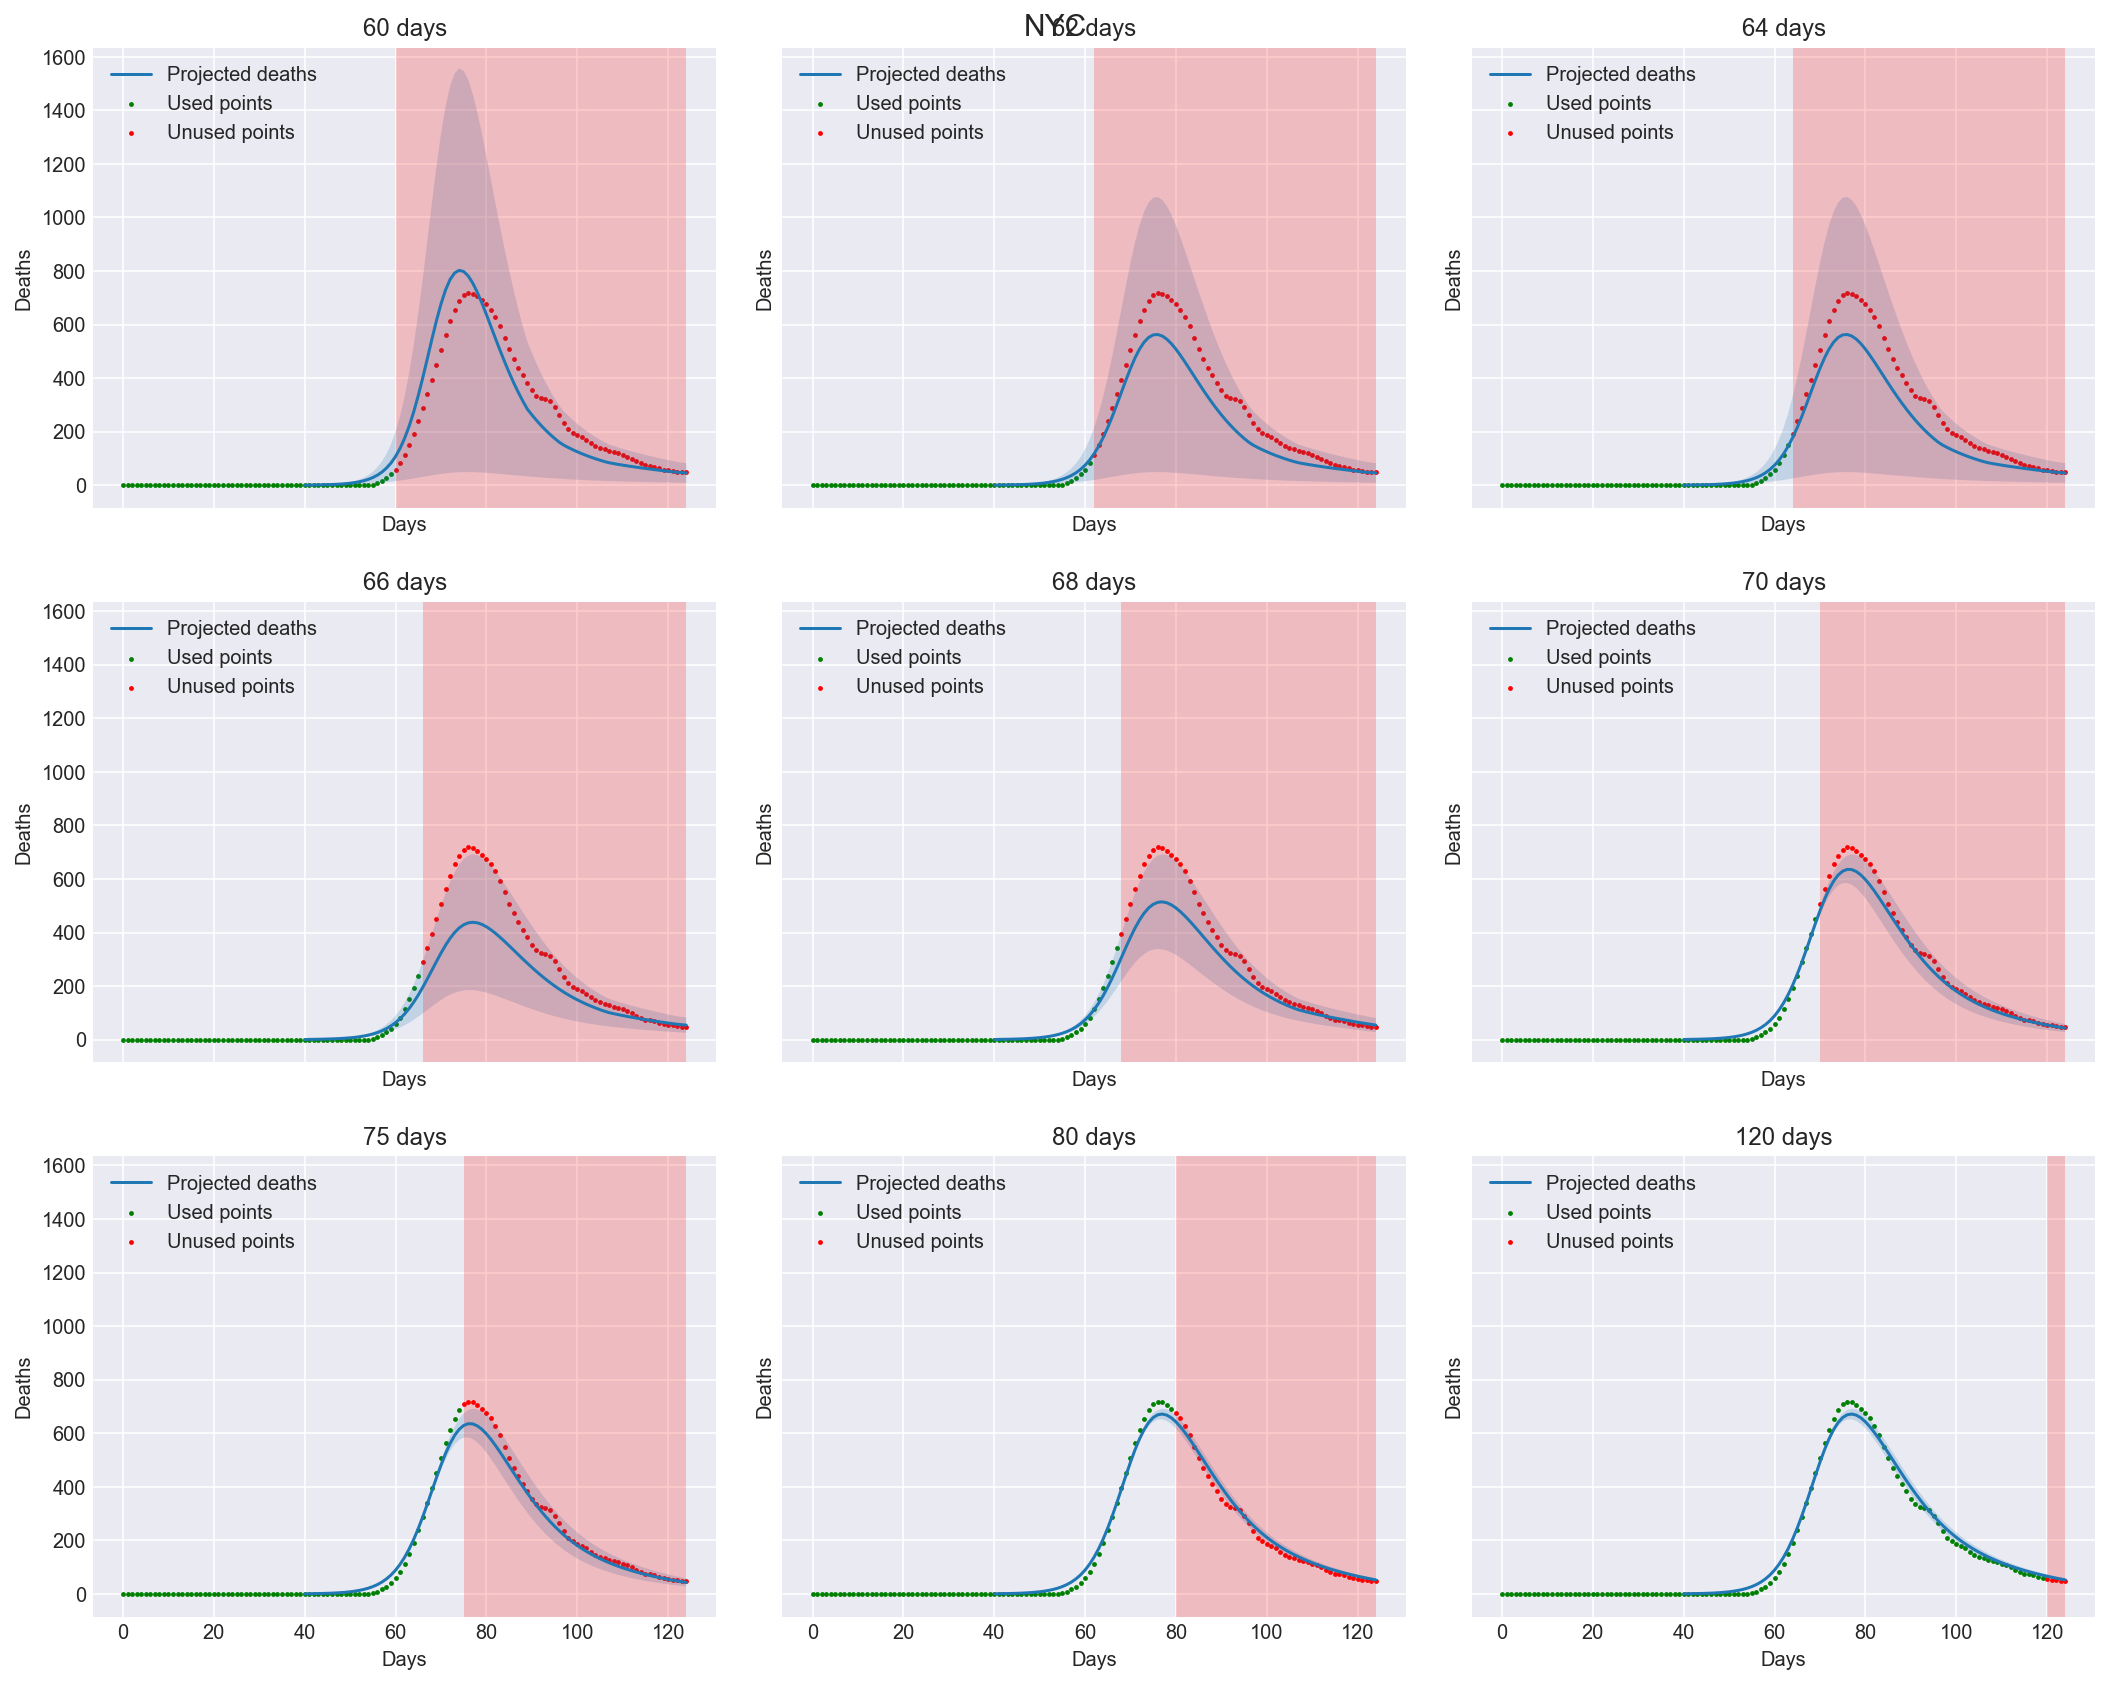

In [1203]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_nyc["total"][0], agg_sd_nyc["total"])) 

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_nyc,
                   breakpoints=[60, 62, 64, 66, 68, 70, 75, 80, 120],
                   plot_title="NYC",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 8.4e6,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 7.4e-5, 
                       "offset"    : 40
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.8, 2.8, 8),
                       "R_min": np.linspace(0.8, 0.95, 4)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                  loss_factor=1000)

<h2>Spain</h2>

Breakpoint  Train Loss  T_inf  sd_offset         pop  gamma_x    I_init  \
0        60.0   31.189322    5.0       23.0  46900000.0   0.0016  0.000013   
0        65.0   32.989177    5.0       23.0  46900000.0   0.0016  0.000013   
0        70.0   37.605522    5.0       23.0  46900000.0   0.0016  0.000013   
0        75.0   36.563183    5.0       23.0  46900000.0   0.0016  0.000013   
0        80.0   37.818194    5.0       23.0  46900000.0   0.0016  0.000013   
0       120.0   35.625694    5.0       23.0  46900000.0   0.0016  0.000013   

   offset  R_max  R_min  
0    25.0    1.9   0.95  
0    25.0    2.0   0.80  
0    25.0    2.0   0.80  
0    25.0    2.0   0.80  
0    25.0    2.0   0.80  
0    25.0    2.0   0.80

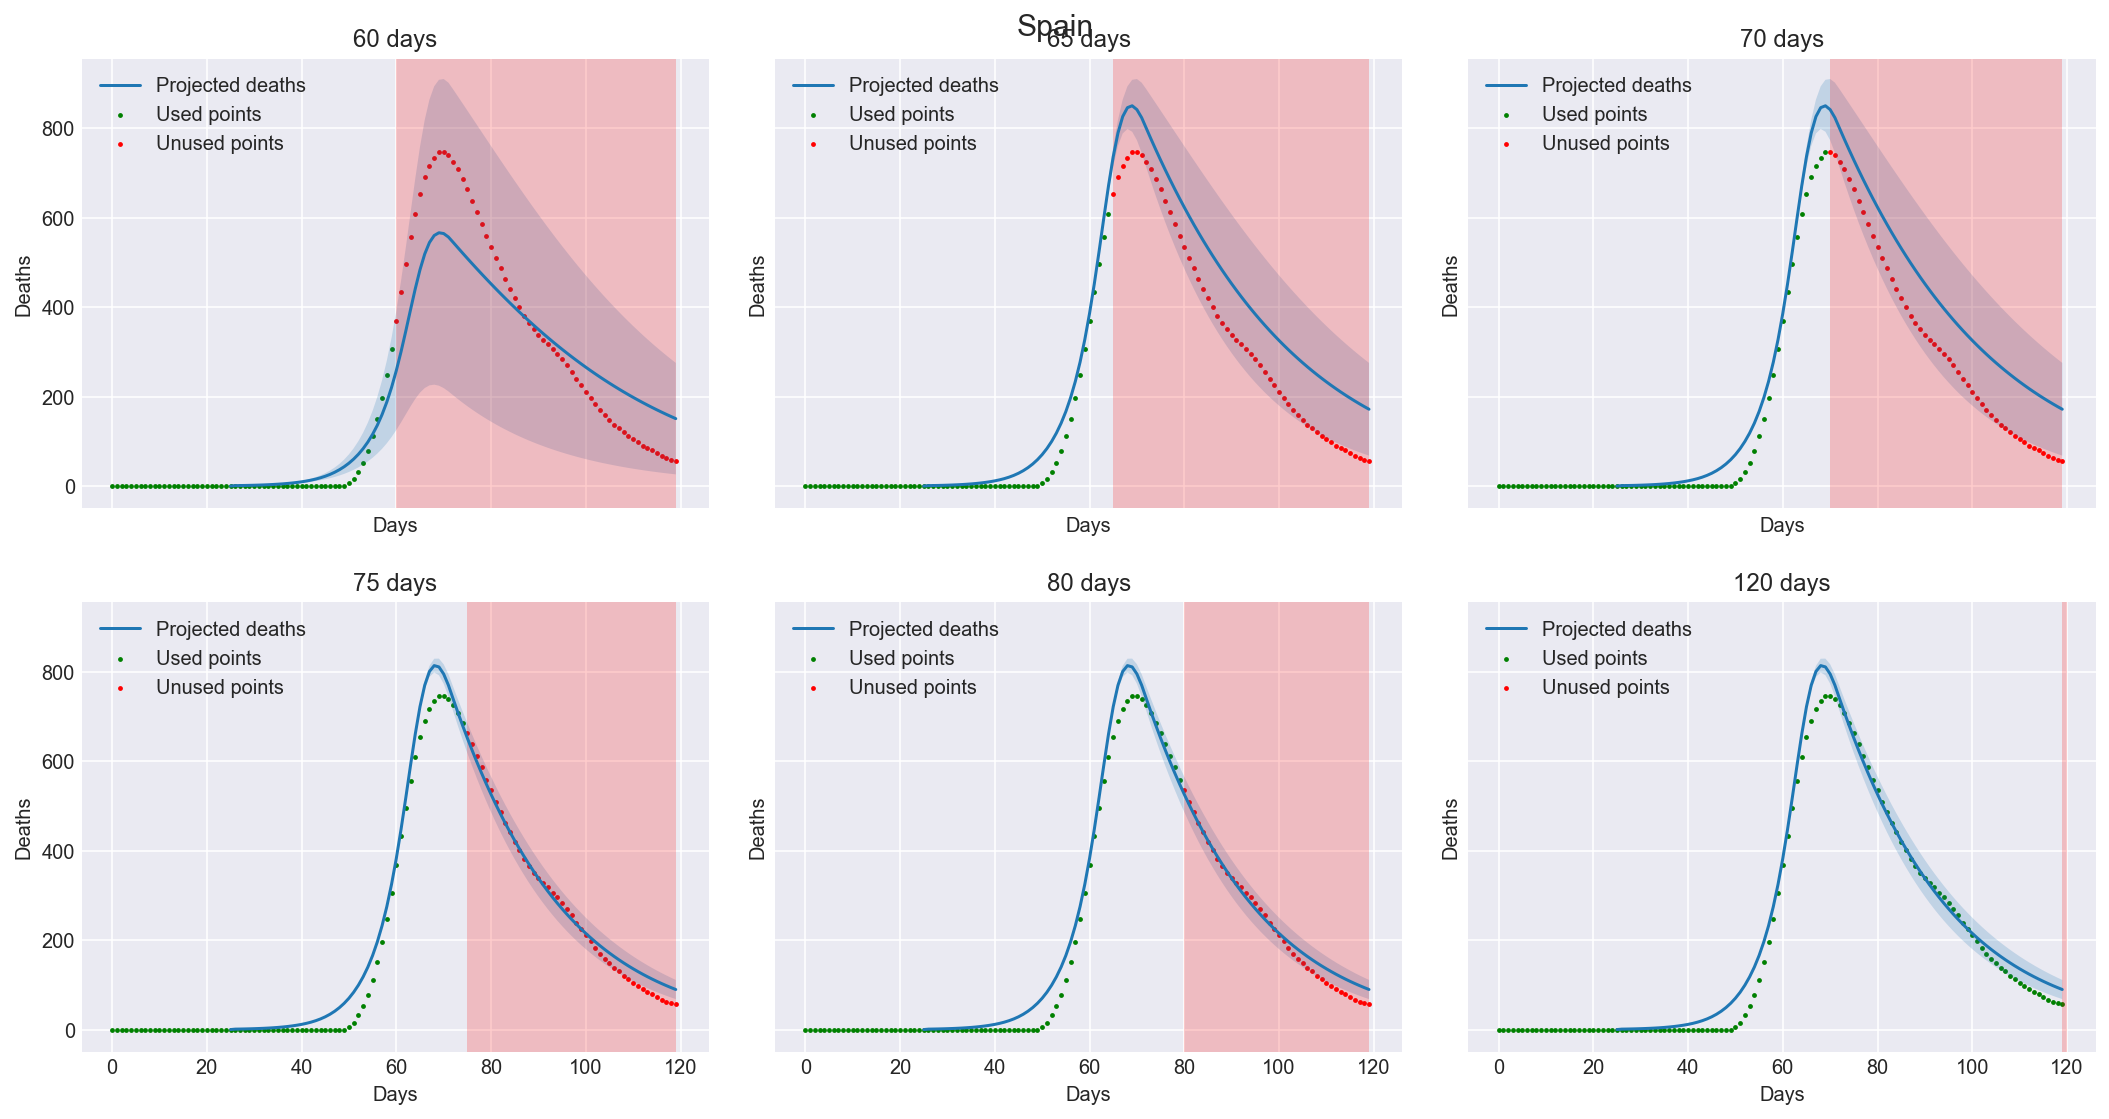

In [1204]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_spain[0], agg_sd_spain))

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_spain,
                   breakpoints=[60, 65, 70, 75, 80, 120],
                   plot_title="Spain",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 4.69e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 1.3e-5, 
                       "offset"    : 25
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.8, 2.5, 8),
                       "R_min": np.linspace(0.8, 0.95, 4)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                  loss_factor=1000)

<h2>Italy</h2>

Breakpoint  Train Loss  T_inf  sd_offset         pop  gamma_x    I_init  \
0        60.0   22.953867    5.0       23.0  60400000.0   0.0016  0.000011   
0        65.0   37.896156    5.0       23.0  60400000.0   0.0016  0.000011   
0        70.0   40.408827    5.0       23.0  60400000.0   0.0016  0.000011   
0        75.0   43.216881    5.0       23.0  60400000.0   0.0016  0.000011   
0        80.0   41.970638    5.0       23.0  60400000.0   0.0016  0.000011   
0       120.0   40.512063    5.0       23.0  60400000.0   0.0016  0.000011   

   offset     R_max     R_min  
0    18.0  1.989474  0.500000  
0    18.0  1.989474  0.500000  
0    18.0  1.989474  0.500000  
0    18.0  1.915789  0.861053  
0    18.0  1.915789  0.886842  
0    18.0  1.915789  0.861053

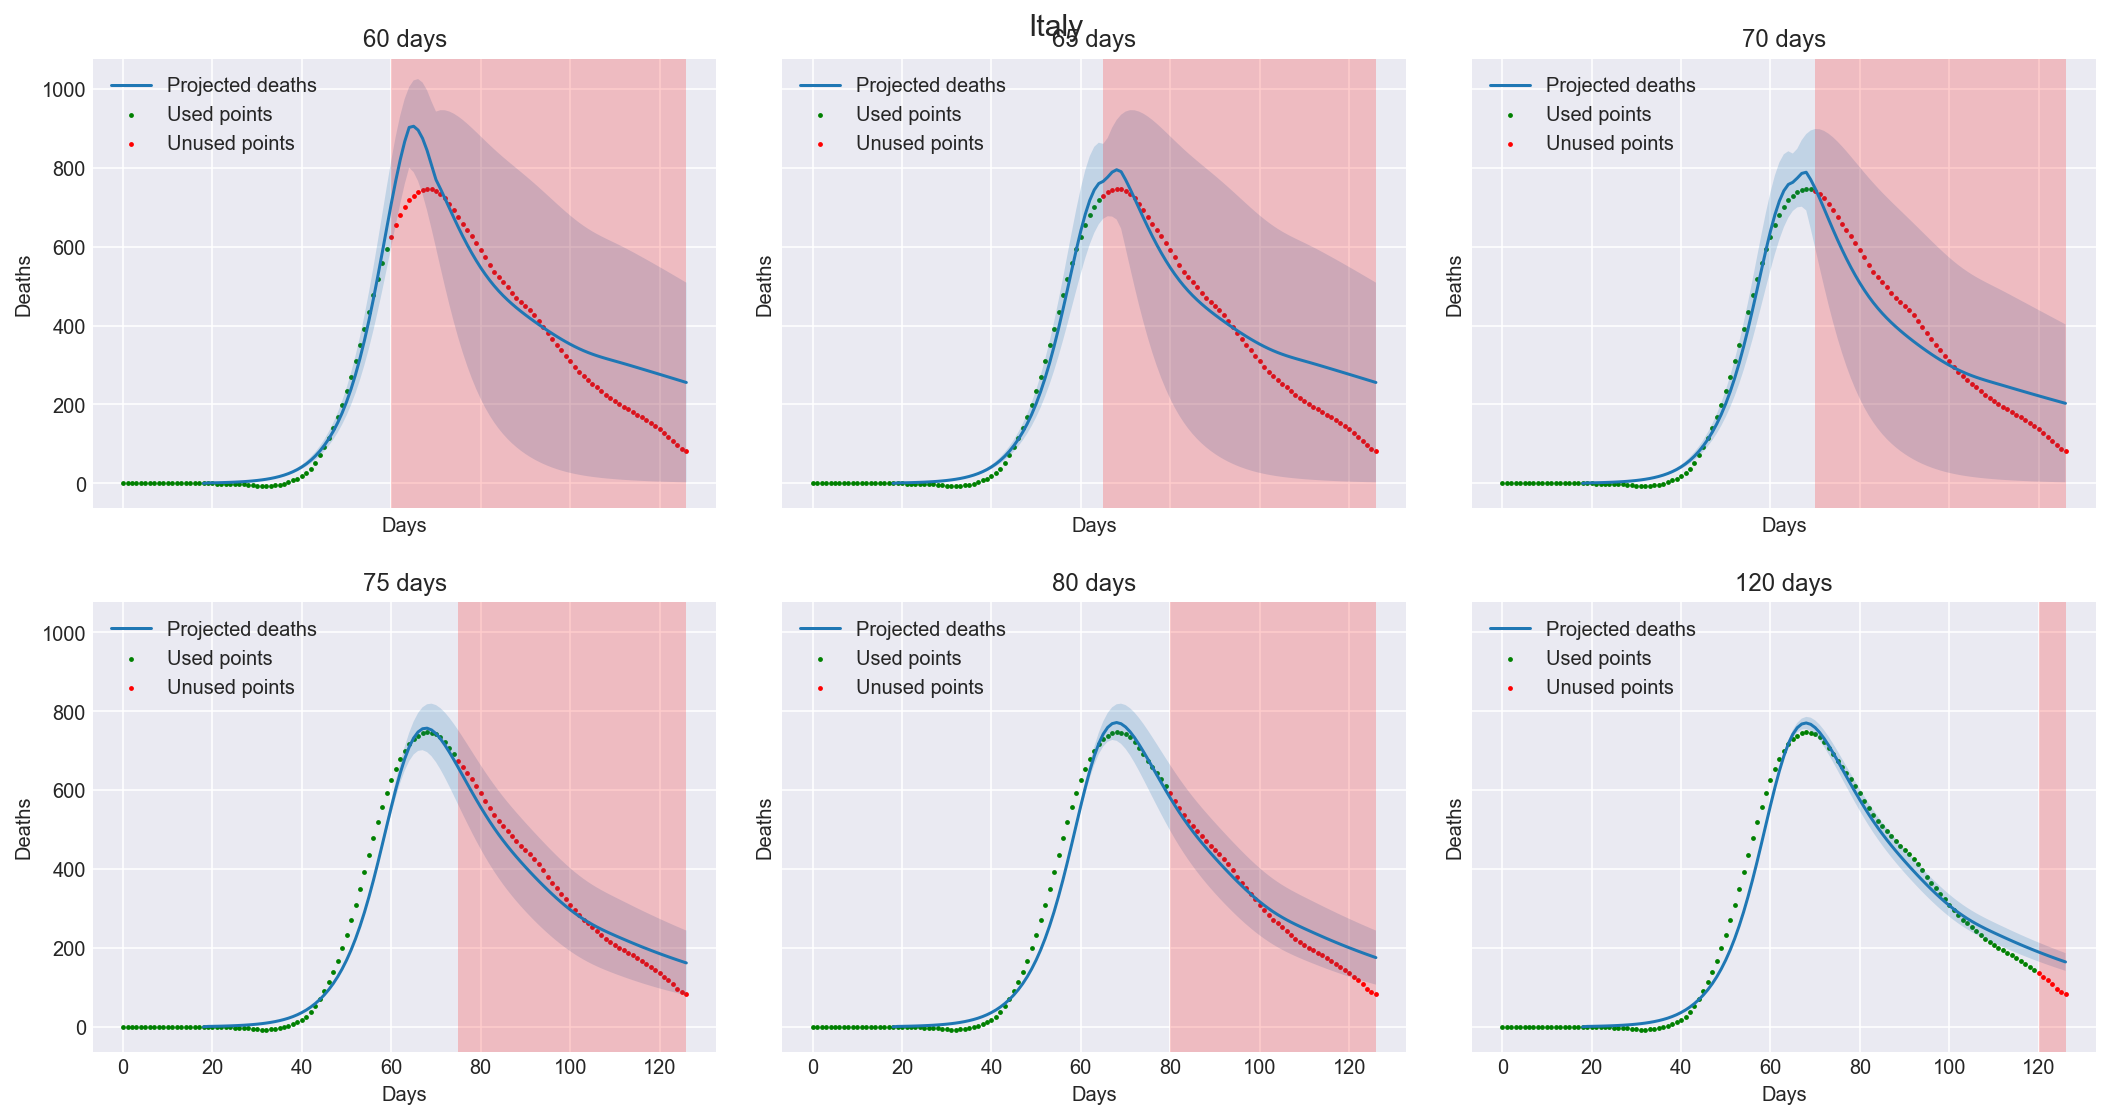

In [1200]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_italy[0], agg_sd_italy)) 

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_italy,
                   breakpoints=[60, 65, 70, 75, 80, 120],
                   plot_title="Italy",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 6.04e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 1.1e-5, 
                       "offset"    : 18
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.4, 2.8, 20),
                       "R_min": np.linspace(0.5, 0.99, 20)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                  loss_factor=800)

# # Aggressive quarantining and testing lead to a lower value for R
# get_model_stats(sird_sd, rmse_loss, smooth_data_italy, list(range(40, 60, 3)) + [100, 120], "SIRD model", 
#                 param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
#                 bounds=[(20, 35), (6.04e7, 6.04e7), (1e-5, 1.1e-5), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.1), (0.80, 0.90), (20, 23)])

<h2>Maharashtra</h2>

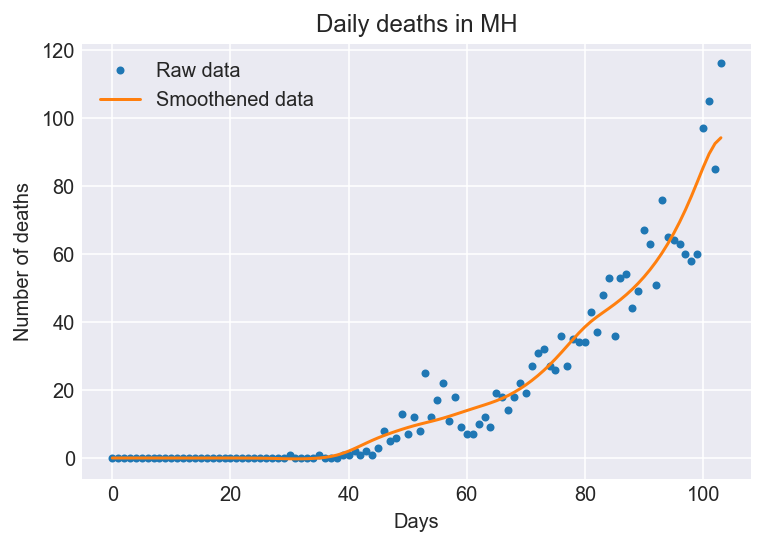

In [1244]:
# Get death data for MH
fetcher = DataFetcherState()
fetcher.fetch()
data_mh = np.array(fetcher.data['mh']['deceased'], dtype=float) # Starting date is 14th March
data_mh = np.concatenate((np.zeros(27), data_mh))

smooth_data_mh = smoothen(smoothen(smoothen(smoothen(savgol_filter(data_mh, 37, 3), 1), 1), 1), 1)
plt.plot(data_mh, '.', label="Raw data")
plt.plot(smooth_data_mh, label="Smoothened data")
plt.title("Daily deaths in MH")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

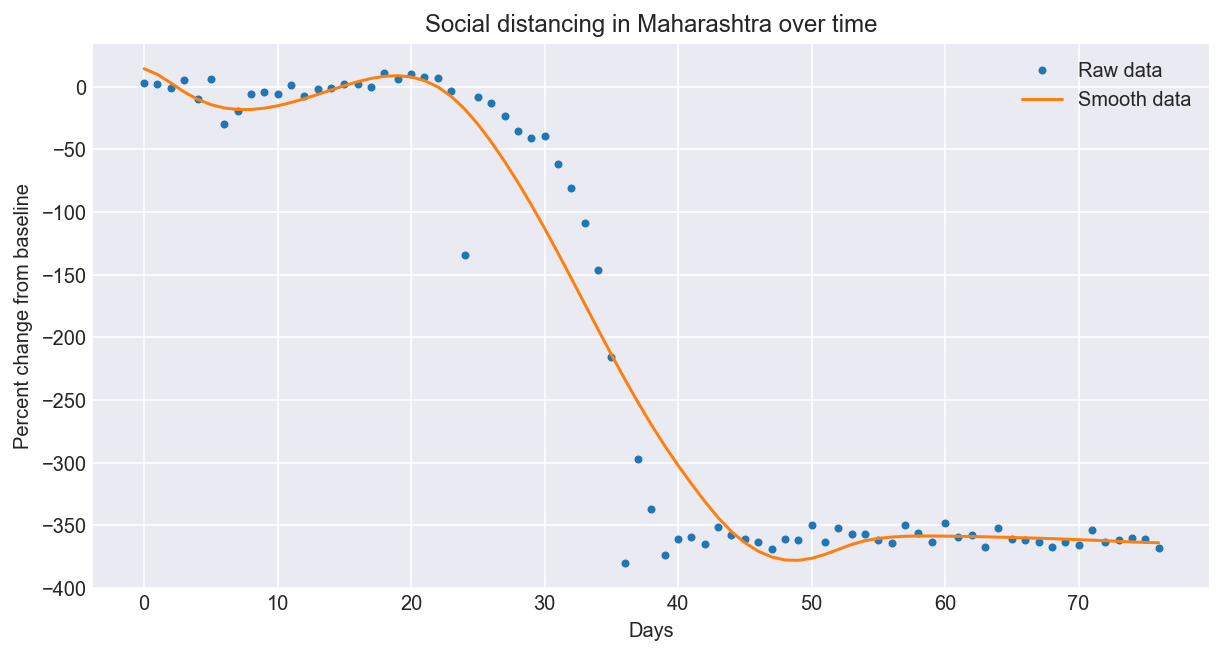

In [1232]:
# Get social distancing data for MH
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd["sub_region_1"] == "Maharashtra"]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_mh = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_mh.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_mh = np.array(agg_sd_mh)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_mh, '.', label="Raw data")
agg_sd_mh = smoothen(smoothen(savgol_filter(agg_sd_mh, 37, 3), 1), 1)
plt.plot(agg_sd_mh, label="Smooth data")
plt.title("Social distancing in Maharashtra over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

Breakpoint  Train Loss  T_inf  sd_offset          pop  gamma_x    I_init  \
0        69.0    2.381588    5.0       23.0  114200000.0   0.0016  0.000005   
0        71.0    2.411337    5.0       23.0  114200000.0   0.0016  0.000005   
0        73.0    2.450452    5.0       23.0  114200000.0   0.0016  0.000005   
0        75.0    2.467876    5.0       23.0  114200000.0   0.0016  0.000005   
0        77.0    2.445261    5.0       23.0  114200000.0   0.0016  0.000005   
0        79.0    2.397324    5.0       23.0  114200000.0   0.0016  0.000005   
0        81.0    2.363658    5.0       23.0  114200000.0   0.0016  0.000005   
0        83.0    2.365729    5.0       23.0  114200000.0   0.0016  0.000005   
0        85.0    2.367599    5.0       23.0  114200000.0   0.0016  0.000005   
0        87.0    2.355765    5.0       23.0  114200000.0   0.0016  0.000005   
0        89.0    2.350879    5.0       23.0  114200000.0   0.0016  0.000005   
0        91.0    2.341602    5.0       23.0  114200000.0   0.0016  0.000005   
0        93.0    2.354199    5.0       23.0  114200000.0   0.0016  0.000005   
0        95.0    2.410810    5.0       23.0  114200000.0   0.0016  0.000005   
0        97.0    2.485102    5.0       23.0  114200000.0   0.0016  0.000005   
0        99.0    2.698947    5.0       23.0  114200000.0   0.0016  0.000005   
0       101.0    2.927759    5.0       23.0  114200000.0   0.0016  0.000005   
0       103.0    3.225600    5.0       23.0  114200000.0   0.0016  0.000005   

   offset     R_max     R_min  
0    30.0  1.457895  1.131579  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.100000  
0    30.0  1.457895  1.110526  
0    30.0  1.457895  1.121053  
0    30.0  1.457895  1.121053  
0    30.0  1.457895  1.131579  
0    30.0  1.457895  1.131579  
0    30.0  1.457895  1.142105  
0    30.0  1.457895  1.142105  
0    30.0  1.457895  1.152632  
0    30.0  1.457895  1.152632  
0    30.0  1.457895  1.163158

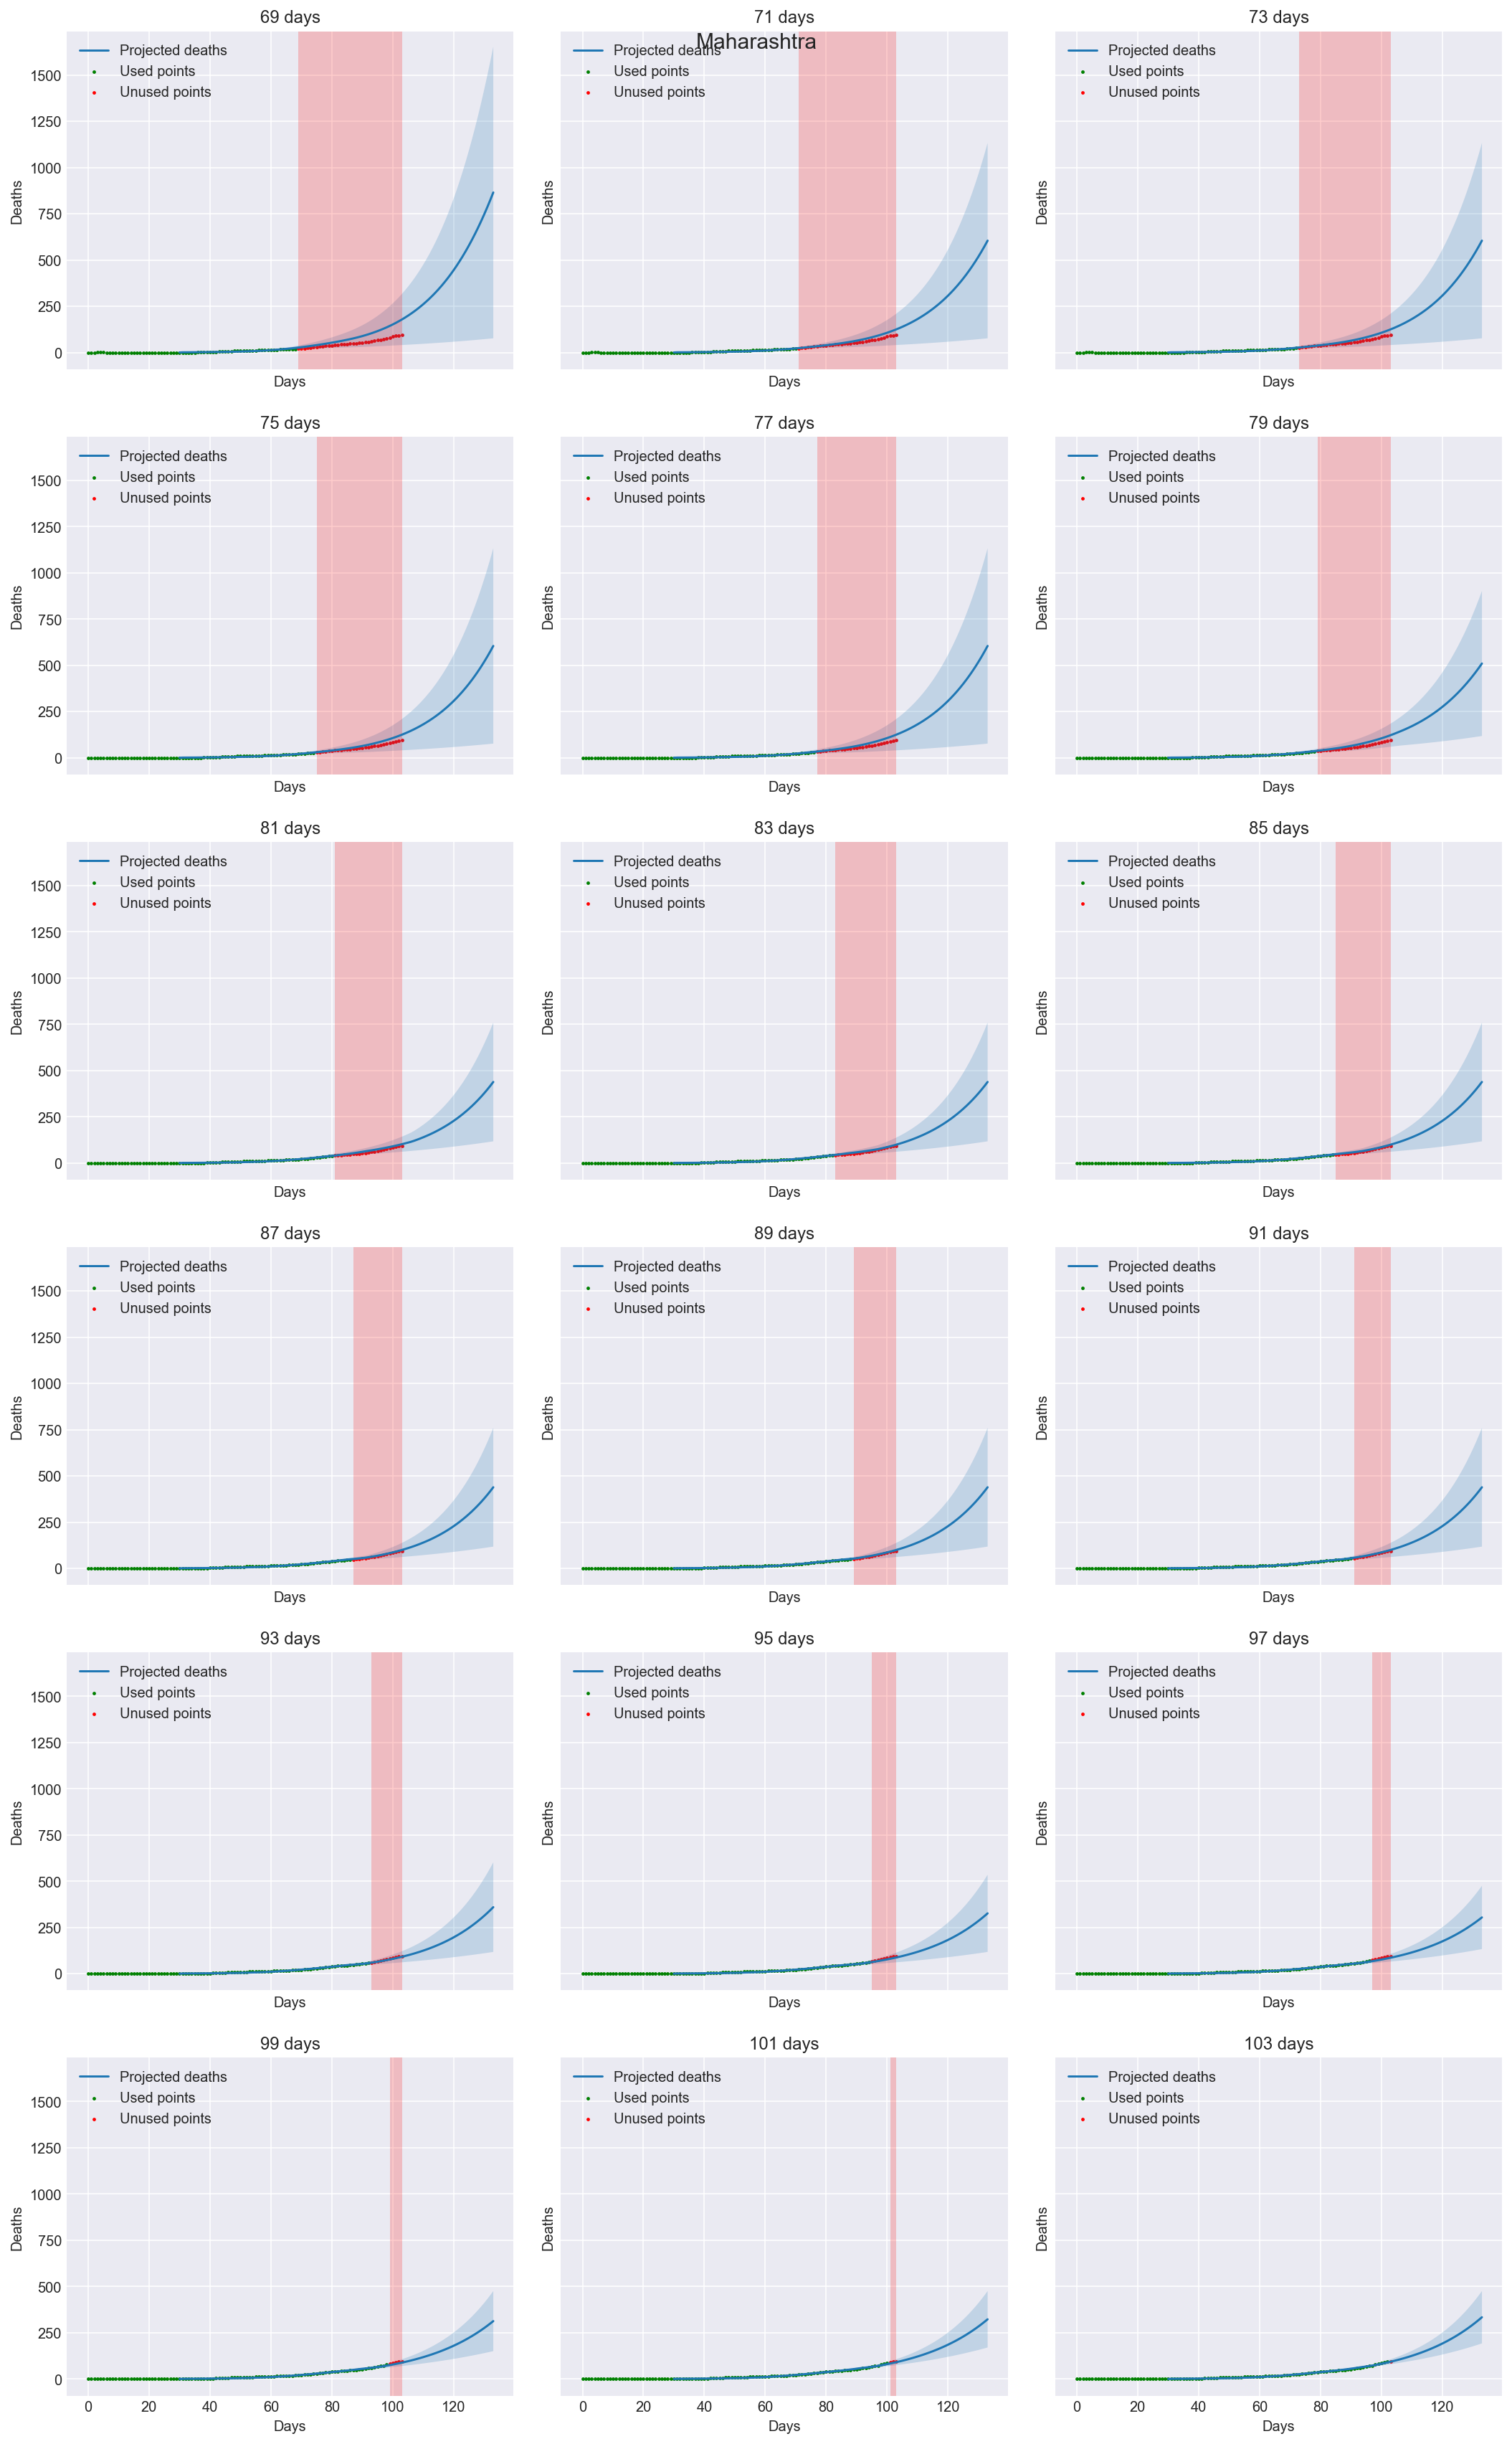

In [1275]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_mh[0], agg_sd_mh)) 

max_len = smooth_data_mh.shape[0]

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_mh,
                   breakpoints=list(range(max_len - 35, max_len, 2)),
                   plot_title="Maharashtra",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 11.42e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 5.47e-6, 
                       "offset"    : 30
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.4, 2.5, 20),
                       "R_min": np.linspace(1.1, 1.3, 20)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                  loss_factor=100,
                  future_preds=30)

# # Aggressive quarantining and testing lead to a lower value for R
# get_model_stats(sird_sd, rmse_loss, smooth_data_italy, list(range(40, 60, 3)) + [100, 120], "SIRD model", 
#                 param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
#                 bounds=[(20, 35), (6.04e7, 6.04e7), (1e-5, 1.1e-5), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.1), (0.80, 0.90), (20, 23)])

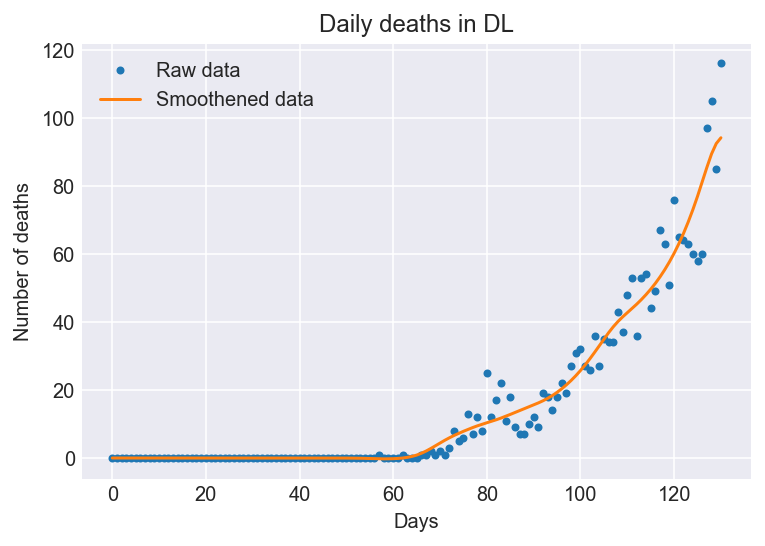

In [1277]:
# Get death data for MH
fetcher = DataFetcherState()
fetcher.fetch()
data_dl = np.array(fetcher.data['dl']['deceased'], dtype=float) # Starting date is 14th March
data_dl = np.concatenate((np.zeros(27), data_mh))

smooth_data_dl = smoothen(smoothen(smoothen(smoothen(savgol_filter(data_dl, 37, 3), 1), 1), 1), 1)
plt.plot(data_dl, '.', label="Raw data")
plt.plot(smooth_data_dl, label="Smoothened data")
plt.title("Daily deaths in DL")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

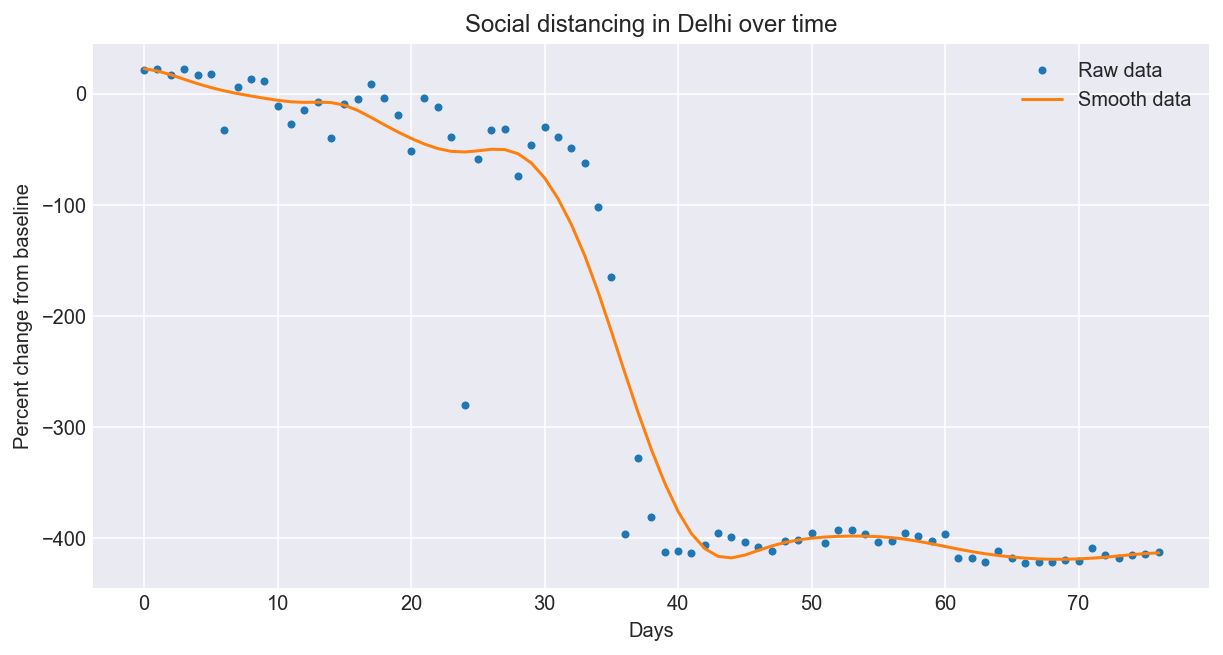

In [1283]:
# Get social distancing data for DL
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd["sub_region_1"] == "Delhi"]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_dl = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_dl.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_dl = np.array(agg_sd_dl)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_dl, '.', label="Raw data")
agg_sd_dl = smoothen(smoothen(smoothen(savgol_filter(agg_sd_dl, 21, 3), 1), 1), 1)
plt.plot(agg_sd_dl, label="Smooth data")
plt.title("Social distancing in Delhi over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

Breakpoint  Train Loss  T_inf  sd_offset         pop  gamma_x    I_init  \
0        96.0    2.562200    5.0       23.0  19000000.0   0.0016  0.000033   
0        98.0    2.561534    5.0       23.0  19000000.0   0.0016  0.000033   
0       100.0    2.584334    5.0       23.0  19000000.0   0.0016  0.000033   
0       102.0    2.631733    5.0       23.0  19000000.0   0.0016  0.000033   
0       104.0    2.717777    5.0       23.0  19000000.0   0.0016  0.000033   
0       106.0    2.838577    5.0       23.0  19000000.0   0.0016  0.000033   
0       108.0    2.980870    5.0       23.0  19000000.0   0.0016  0.000033   
0       110.0    3.030353    5.0       23.0  19000000.0   0.0016  0.000033   
0       112.0    3.072987    5.0       23.0  19000000.0   0.0016  0.000033   
0       114.0    3.096590    5.0       23.0  19000000.0   0.0016  0.000033   
0       116.0    3.055757    5.0       23.0  19000000.0   0.0016  0.000033   
0       118.0    3.017042    5.0       23.0  19000000.0   0.0016  0.000033   
0       120.0    2.979313    5.0       23.0  19000000.0   0.0016  0.000033   
0       122.0    2.944635    5.0       23.0  19000000.0   0.0016  0.000033   
0       124.0    2.929388    5.0       23.0  19000000.0   0.0016  0.000033   
0       126.0    2.980608    5.0       23.0  19000000.0   0.0016  0.000033   
0       128.0    3.171669    5.0       23.0  19000000.0   0.0016  0.000033   
0       130.0    3.463094    5.0       23.0  19000000.0   0.0016  0.000033   

   offset  R_max     R_min  
0    40.0    1.4  1.131579  
0    40.0    1.4  1.142105  
0    40.0    1.4  1.142105  
0    40.0    1.4  1.152632  
0    40.0    1.4  1.163158  
0    40.0    1.4  1.173684  
0    40.0    1.4  1.184211  
0    40.0    1.4  1.184211  
0    40.0    1.4  1.184211  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737  
0    40.0    1.4  1.194737

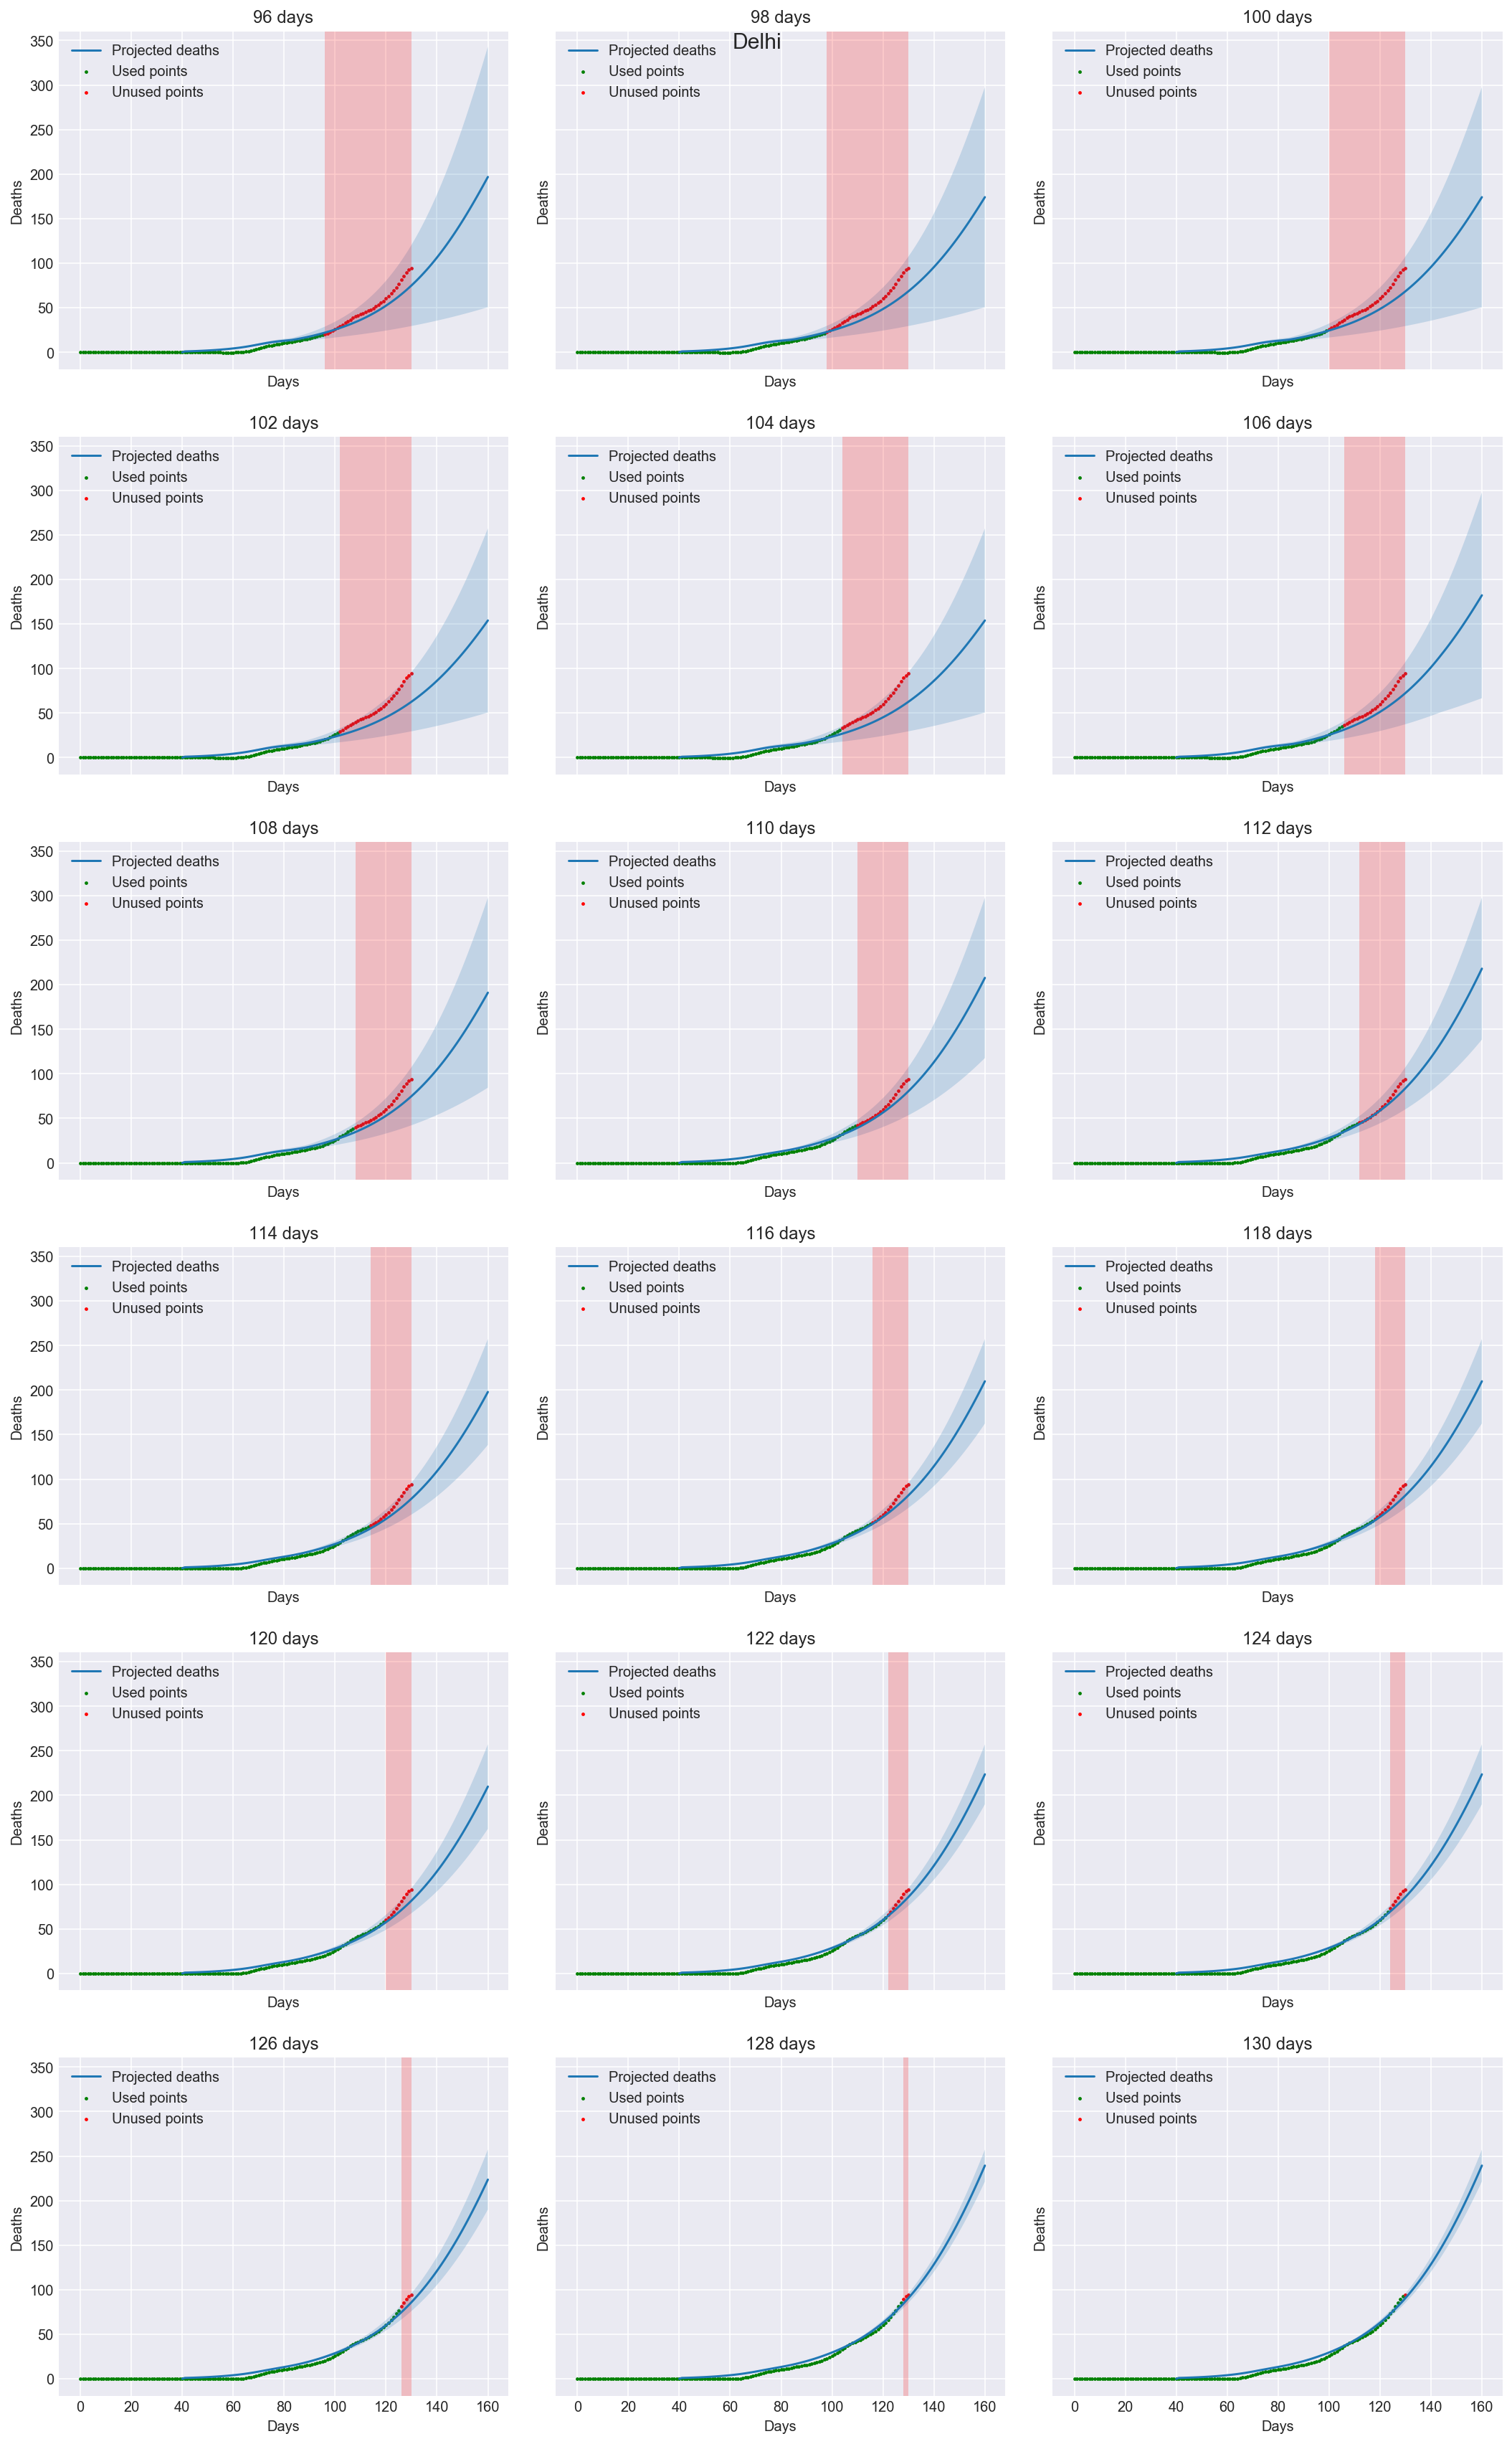

In [1289]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_dl[0], agg_sd_dl)) 

max_len = smooth_data_dl.shape[0]

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_dl,
                   breakpoints=list(range(max_len - 35, max_len, 2)),
                   plot_title="Delhi",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 1.9e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 3.28e-5, 
                       "offset"    : 40
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.4, 2.5, 20),
                       "R_min": np.linspace(1.1, 1.3, 20)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
                  loss_factor=100,
                  future_preds=30)

# # Aggressive quarantining and testing lead to a lower value for R
# get_model_stats(sird_sd, rmse_loss, smooth_data_italy, list(range(40, 60, 3)) + [100, 120], "SIRD model", 
#                 param_cols=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset"],
#                 bounds=[(20, 35), (6.04e7, 6.04e7), (1e-5, 1.1e-5), (5.0, 5.0), (1.6e-3, 1.6e-3), (1.8, 2.1), (0.80, 0.90), (20, 23)])